# ALZHEIMER'S DETECTION

Giulio Fabbri e Valentina Coppi

<!-- vscode-markdown-toc -->

0. [Introduction](#1.-Introduction)
1. [Load the data](#1.-Load-the-data)

2. [Data visualization](#2.-Data-visualization)

3. [CNN with two classes](#3.-CNN-with-two-classes)    
  3.1. [Data splitting](###3.1-Data-splitting)  
  3.2. [ResNet](###3.2-ResNet)  
  3.3. [VGG16](###3.3-VGG16)  
  3.4. [InceptionV3](###3.4-InceptionV3)  
  3.5. [MobileNet](###3.5-MobileNet)  
  3.6. [EfficientNet](#3.6-EfficientNet)  

4. [CNN with data augmentation](#4.-CNN-with-data-augmentation)  
  4.1. [Data splitting](###4.1-Data-splitting)  
  4.2. [ResNet](###4.2-ResNet)  
  4.3. [VGG16](###4.3-VGG16)  
  4.4. [InceptionV3](###4.4-InceptionV3)  
  4.5. [MobileNet](###4.5-MobileNet)  
  4.6. [EfficientNet](#4.6-EfficientNet)  

5. [CAM interpretation ](#5.-CAM-interpretation)

# 0. Introduction

Our goal in this project is to study an approach to CNNs that can best recognize the signs of Alzheimer's disease in a brain scan image.  

The dataset used is taken from kaggle https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images  
and contains 6400 brain scan images divided into 4 classes.  

We will download and visualize the images and then use two approaches:  
1. Balance the classes by dividing the images into sick vs. non-sick;  
2. Maintain the 4 classes by balancing them through data augmentation (SMOOTE).  

For each approach we will test 5 models that are already pre-trained, since to train a CNN on this complexity of images would take too much time.  

To fit the pre-trained CNNs to our data, we added layers that take the output of the pre-trained models and learn to classify it by categories.  
For this reason the training time is greatly reduced because we only train the layers that interpret the output of the pre-trained CNNs.  

In the end, since the explainability of ML models in the medical field is of paramount importance, we will use the CAM (Class activation Map) method  to be able to visualize which part of the imageries are most used for prediction purposes.   
In a real application this would serve to show the doctor which part of the brain are most initeresting to understand the health status of the subject.

# 1. Load the data

In [18]:
#pip install -U imbalanced-learn

In [19]:
#pip install opencv-python

In [20]:
#pip install keras

In [21]:
#pip install tensorflow

In [22]:
import pandas as pd
import os 
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import randint
import imageio as iio
from keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses, Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications import MobileNet, MobileNetV3Small
from keras.applications import EfficientNetB0
from keras.applications import ResNet152
import keras 
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [23]:
image = []
label = []
data_path = r'C:\Users\bslab2-studente\Downloads\archive\Alzheimer_s Dataset'
for subfolder in tqdm(os.listdir(data_path)):
    subfolder_path = os.path.join(data_path, subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            image.append(image_path)
            label.append(folder)
df = pd.DataFrame({'image': image, 'label': label})
df

100%|██████████| 2/2 [00:00<00:00, 91.16it/s]


image             label
0     C:\Users\bslab2-studente\Downloads\archive\Alz...      MildDemented
1     C:\Users\bslab2-studente\Downloads\archive\Alz...      MildDemented
2     C:\Users\bslab2-studente\Downloads\archive\Alz...      MildDemented
3     C:\Users\bslab2-studente\Downloads\archive\Alz...      MildDemented
4     C:\Users\bslab2-studente\Downloads\archive\Alz...      MildDemented
...                                                 ...               ...
6395  C:\Users\bslab2-studente\Downloads\archive\Alz...  VeryMildDemented
6396  C:\Users\bslab2-studente\Downloads\archive\Alz...  VeryMildDemented
6397  C:\Users\bslab2-studente\Downloads\archive\Alz...  VeryMildDemented
6398  C:\Users\bslab2-studente\Downloads\archive\Alz...  VeryMildDemented
6399  C:\Users\bslab2-studente\Downloads\archive\Alz...  VeryMildDemented

[6400 rows x 2 columns]


# 2. Data visualization

Our dataset contains only the image path with its label, to actually display the image we need to use imread().

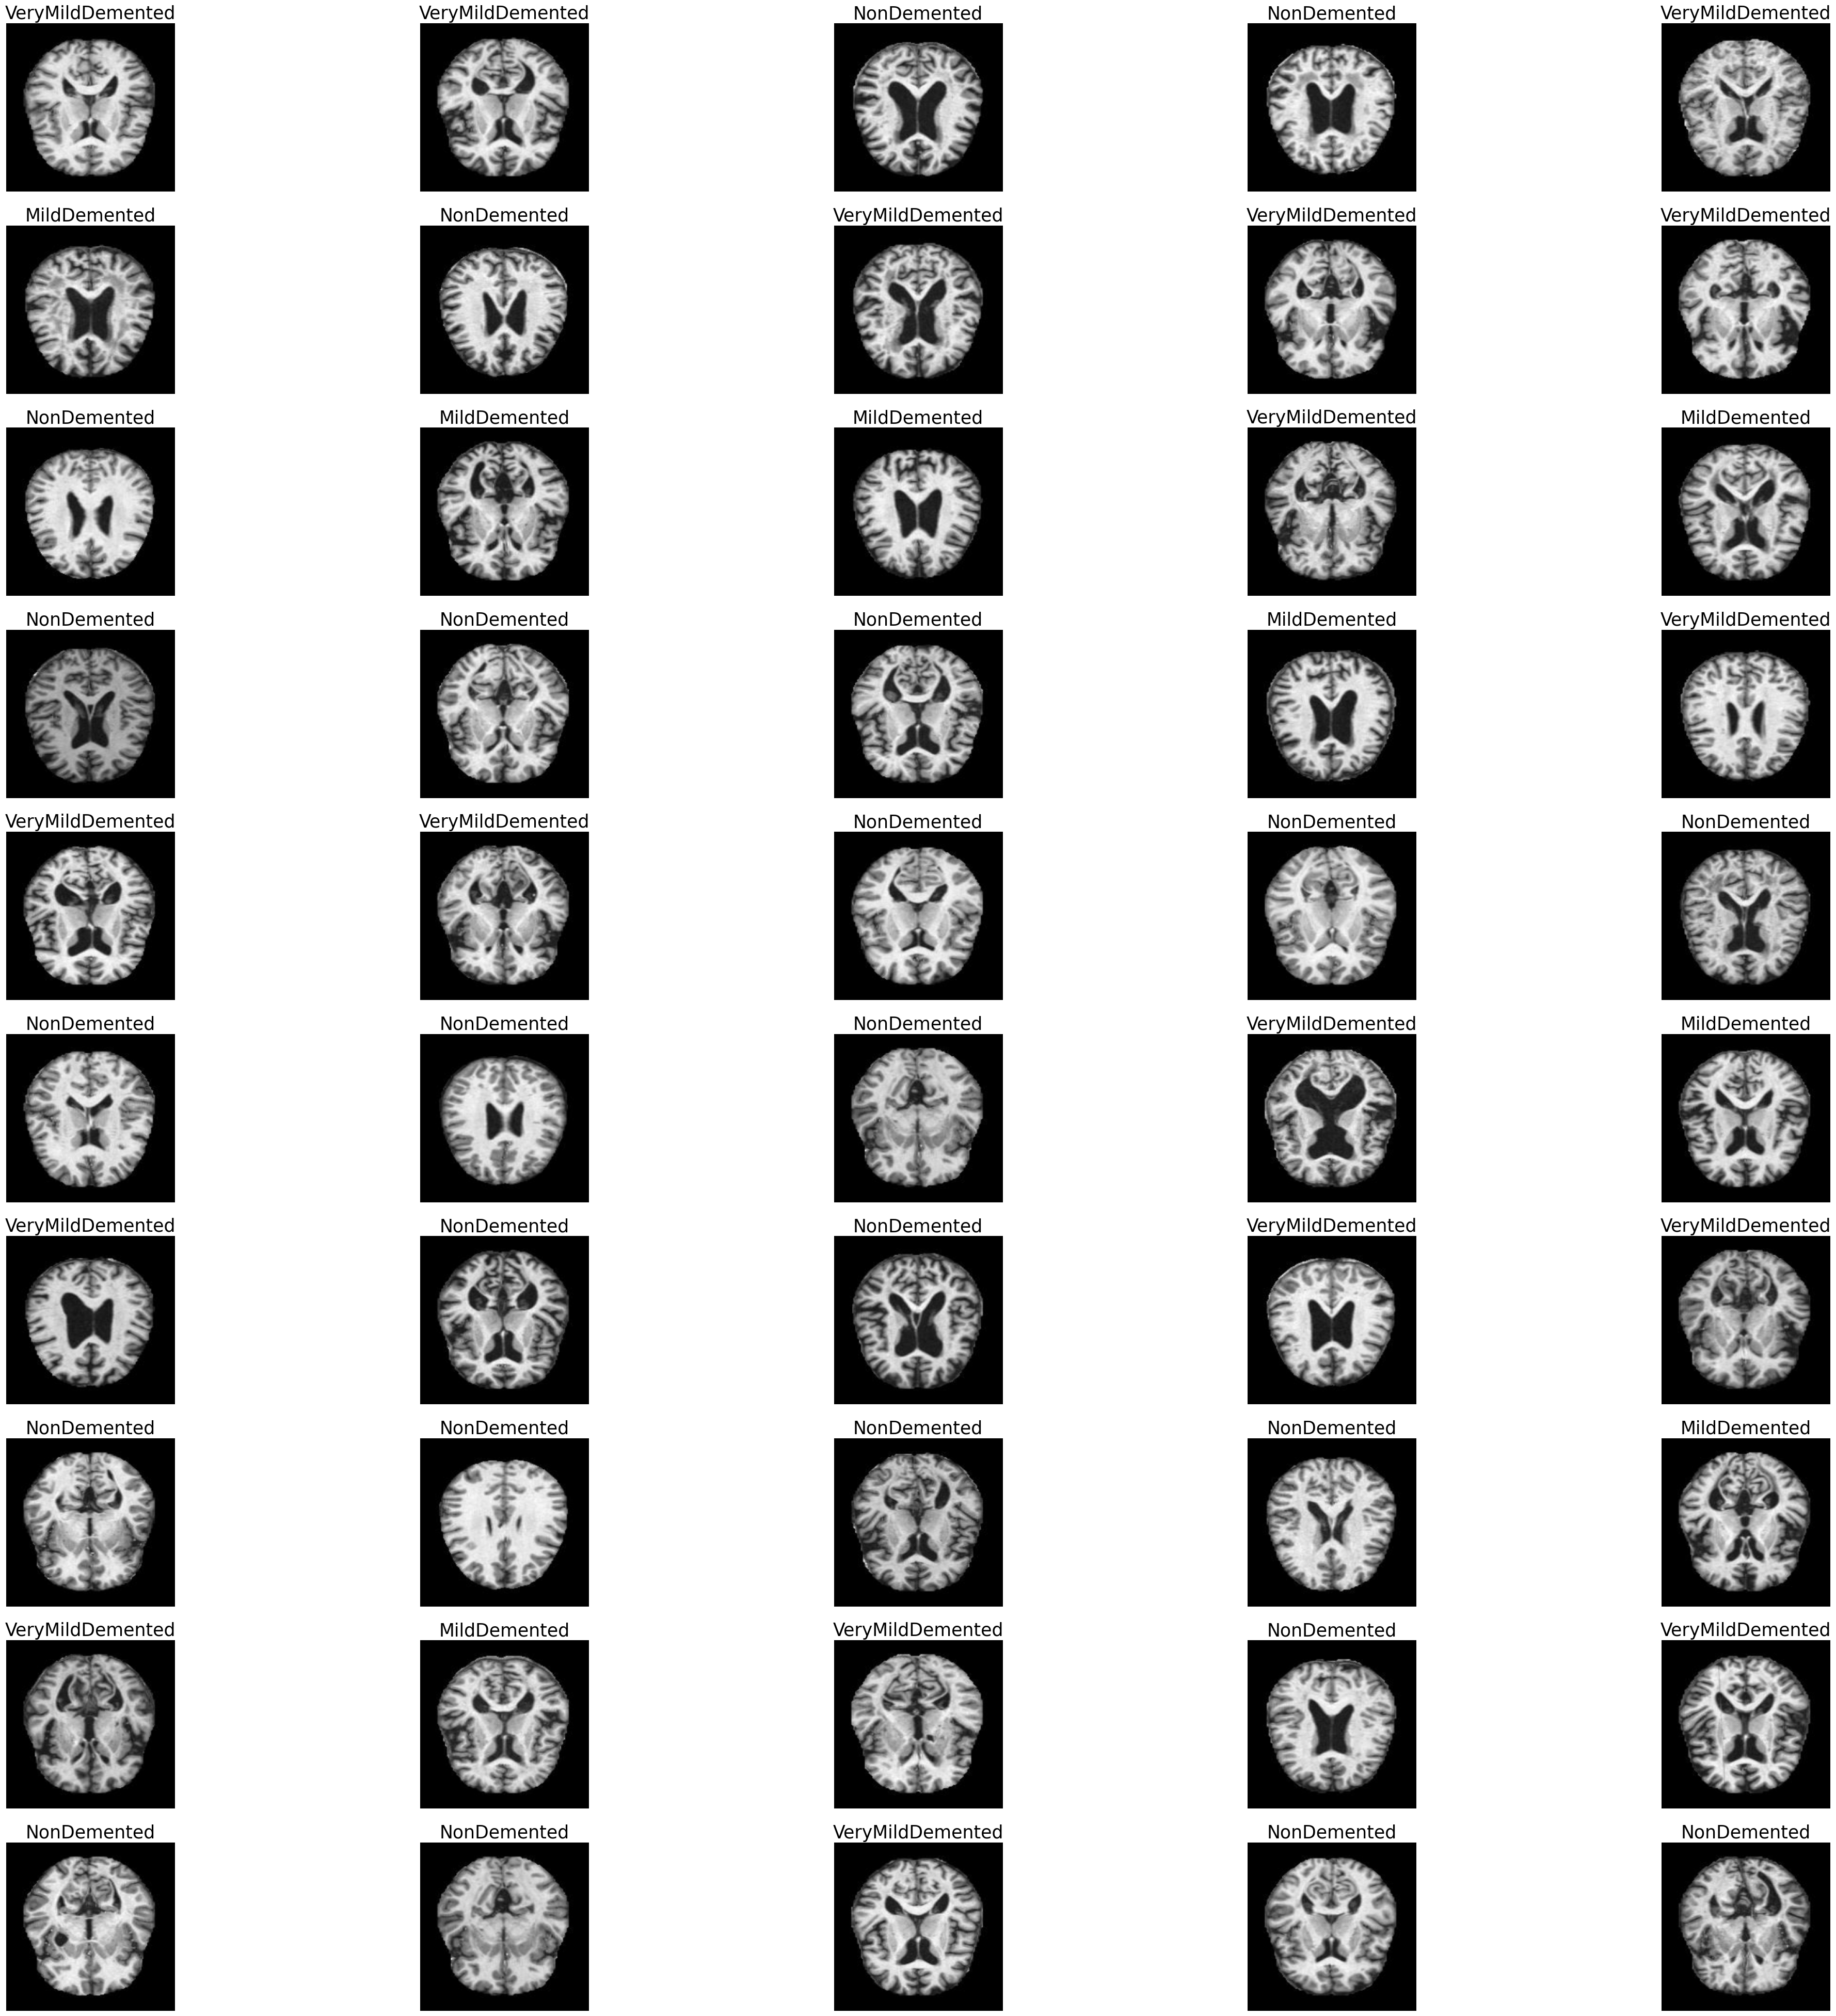

In [24]:
plt.figure(figsize=(50,50))
# take 50 random photos
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    # read the image, resize, black and white
    img= iio.v2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # plot 
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

Each image can be classified according to 4 labels
- NonDemented;         
- VeryMildDemented;  
- MildDemented;         
- ModerateDemented.

The classes are very unbalanced with most patients classified as not sick or seriously sick .

In [25]:
# Number of photos in each class
df['label'].value_counts()

label
NonDemented         3200
VeryMildDemented    2240
MildDemented         896
ModerateDemented      64
Name: count, dtype: int64

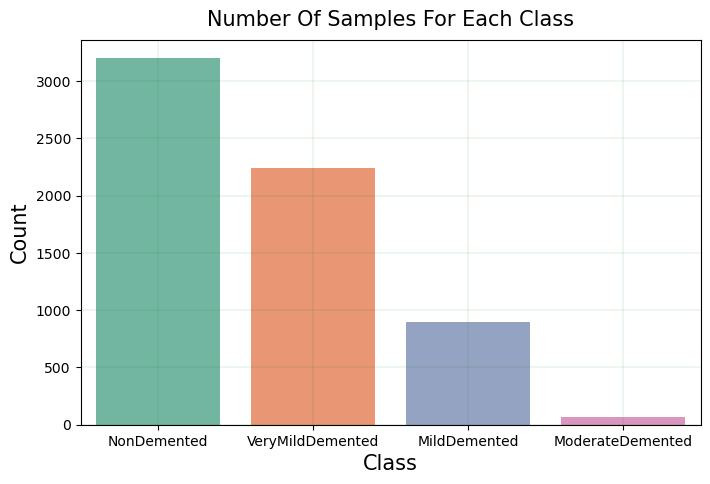

In [26]:
plt.figure(figsize=(8,5))
ax = sns.countplot(x=df.label,order= ['NonDemented','VeryMildDemented','MildDemented','ModerateDemented'],palette="Set2")
ax.set_xlabel("Class",fontsize=15)
ax.set_ylabel("Count",fontsize=15)
plt.title('Number Of Samples For Each Class',fontsize=15, pad= 10)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

We can easily notice that the four classes are highly unbalanced.
However, we can solve the imbalance between classes very simply by aggregating them into 2 classes that simply tell us whether the image is from a sick patient or not, without considering the severity.

The two classes therefore are: 
- **Sick** (Moderate + MIld + Very Mild Demented ): people who suffer from Alzheimer, no matter the degree of gravity; 
- **Not Sick** (Non Demented): people who do not suffer form Alzheimer. 

In this way we obtain a perfeclty balanced label system.

In [27]:
# divide images in Sick and Not Sick
df['label2']=np.zeros
for i in range(0, len(df['label'])): 
    if df['label'][i]== 'NonDemented':
        df['label2'][i]= 'Not Sick'
    else:
        df['label2'][i]= 'Sick'

# The two classes are balanced 
df['label2'].value_counts()

label2
Sick        3200
Not Sick    3200
Name: count, dtype: int64

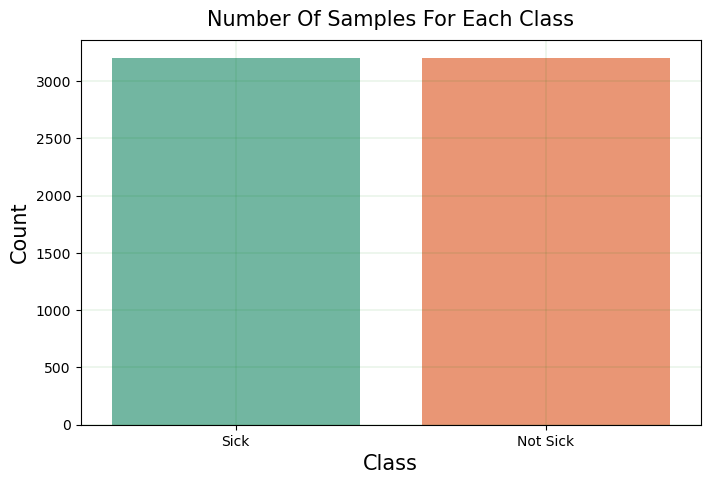

In [28]:
plt.figure(figsize=(8,5))
ax = sns.countplot(x=df.label2,palette="Set2")
ax.set_xlabel("Class",fontsize=15)
ax.set_ylabel("Count",fontsize=15)
plt.title('Number Of Samples For Each Class',fontsize=15, pad= 10)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

# 3. CNN with two classes

### 3.1 Data splitting

After having split the data between the sick and not sick classes we can make the training/test partition.  

In this case we are going to use 
1. ImageDataGenerator() that is a tensorflow class for generating data, used without specifying the augmentation function to be used in order to use the original data instead of generating new; 

2. work_dr.flow_from_dataframe() to generate the data from our image paths dataset, meaning transforming them into a tensor representation. 




In [29]:
Size=(100,100)

work_dr = ImageDataGenerator(rescale = 1./255)    

data_gen = work_dr.flow_from_dataframe(df,
                                       x_col='image',
                                       y_col='label2',
                                       target_size=Size,
                                       batch_size=6400,   # take all the 6400 images
                                       shuffle=False)


Found 6400 validated image filenames belonging to 2 classes.


In [30]:
# data and labels in tensor representation 
new_data, new_labels = data_gen.next()  # next batch of data

In [31]:
# data splitting in training e test 
X_train, X_test, y_train, y_test = train_test_split(new_data,new_labels, test_size=0.2, random_state=42,shuffle=True,stratify=new_labels)

print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (5120, 100, 100, 3)
X_test shape is  (1280, 100, 100, 3)
y_train shape is  (5120, 2)
y_test shape is  (1280, 2)


For checking that the process is going fine we use a function for getting the feature name and one for showing the images.  

We can see that the data have been transformed into tensors correctly, without undergoing data augmentation and keeping the labels.

In [32]:
def get_feature_name(id):
    human_readable_lablels = ['Sick',
                              'Not Sick']
    return human_readable_lablels[id]

In [33]:
def show_images(ds_x, ds_y, num_row, num_col):
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        img_id = randint(len(ds_y))
        ax = axes[i//num_col, i%num_col]
        ax.imshow(ds_x[img_id], cmap='gray_r')
        ylabel = np.argmax(ds_y[img_id])
        ax.set_title('{}:{}'.format(get_feature_name(ylabel), ylabel), fontsize= 8)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()

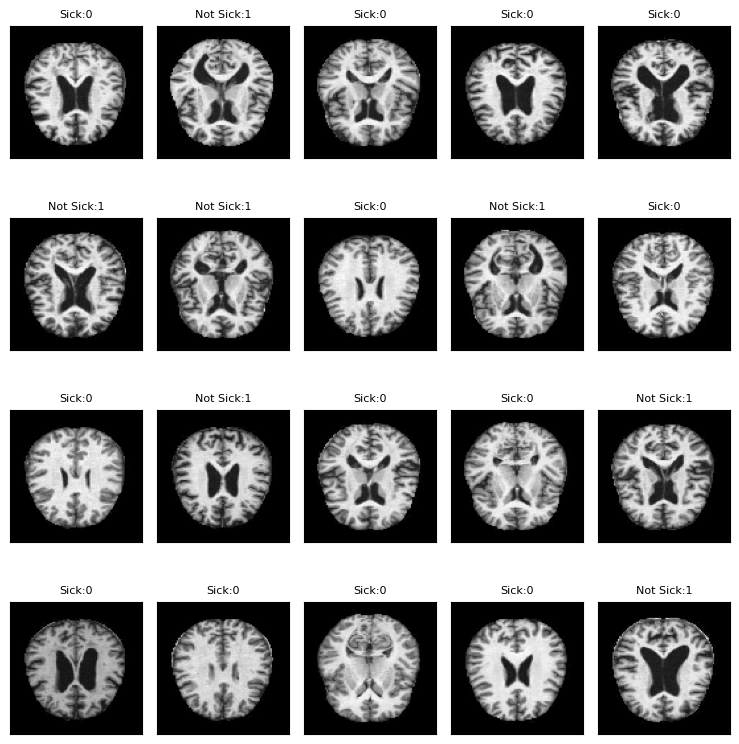

In [34]:
show_images(X_train, y_train, 4,5)

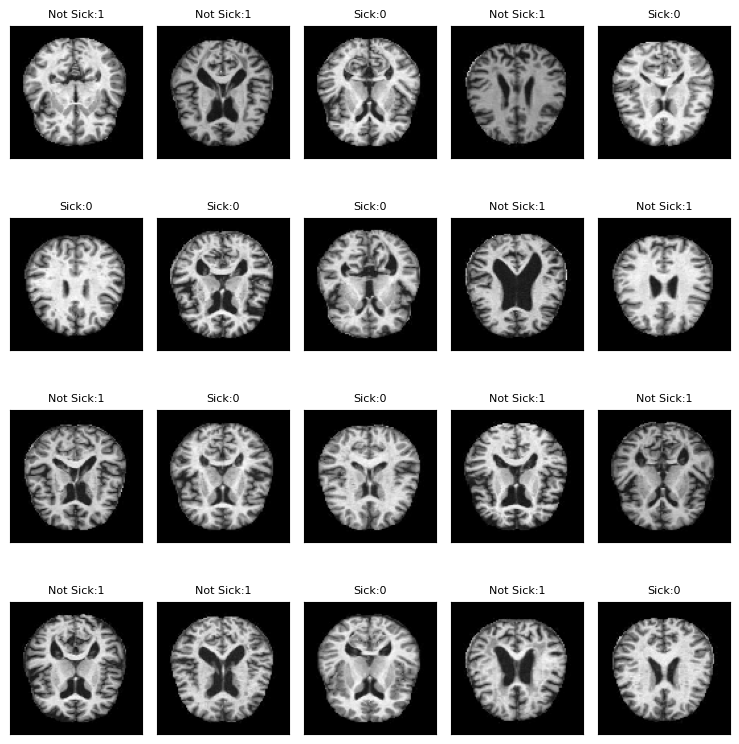

In [35]:
show_images(X_test, y_test, 4,5)

In addition, by using the partition into two classes, we maintained the balance in both training and testing. 

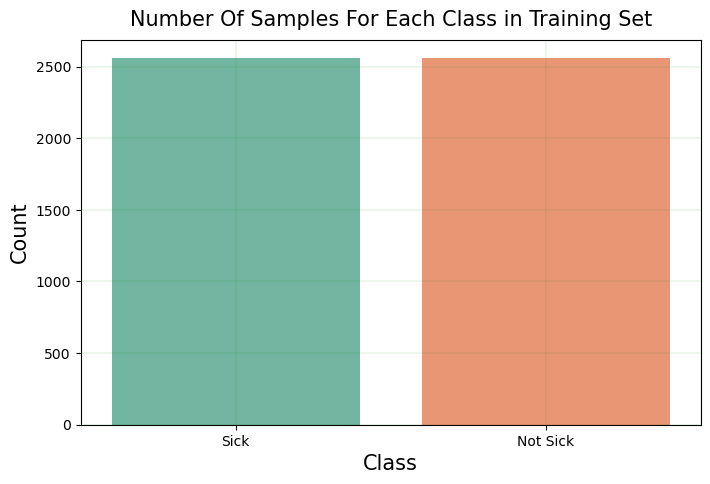

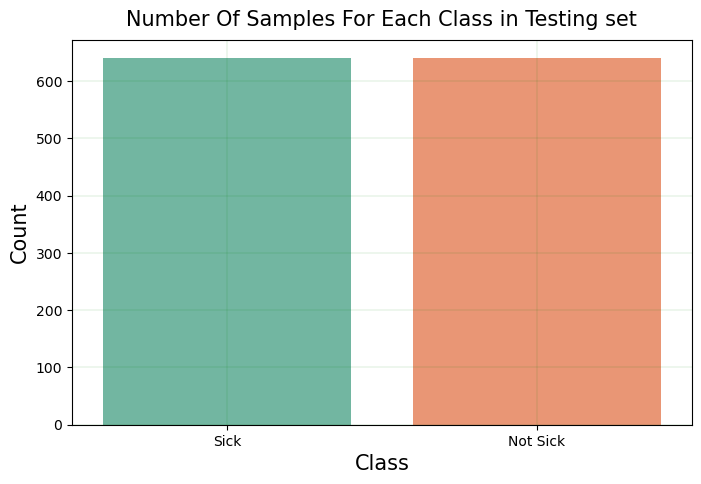

In [36]:
# order the classes 
class_num=np.sort(['Sick','Not Sick'])

# plot the classes distribution in training set 
labels=[class_num[i] for i in np.argmax(y_train,axis=1) ]
plt.figure(figsize=(8,5))
ax = sns.countplot(x=labels,order=['Sick', 'Not Sick'], palette="Set2")
ax.set_xlabel("Class",fontsize=15)
ax.set_ylabel("Count",fontsize=15)
plt.title('Number Of Samples For Each Class in Training Set',fontsize=15, pad= 10)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

# plot the classes distribution in test set 
labels=[class_num[i] for i in np.argmax(y_test,axis=1) ]
plt.figure(figsize=(8,5))
ax = sns.countplot(x=labels,order=['Sick', 'Not Sick'], palette="Set2")
ax.set_xlabel("Class",fontsize=15)
ax.set_ylabel("Count",fontsize=15)
plt.title('Number Of Samples For Each Class in Testing set',fontsize=15, pad= 10)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

### 3.2 ResNet

ResNet exploits the concept of residual learning for improving the AlexNet CNN approach.

AlexNet has been improved over the years by adding layers, which, however, generates the problem of vanishing gradient.

ResNet compose the architecture stacking various Residual Blocks that use skip connections to propagate a layer informations to further layers skipping the layers in between.

So instead of learning the mapping function H(x) of our data x the NN aim to learn the residual mapping aim to learn the residual mapping F(x)=H(x)−x.

This means that the ResNet instead of trying to learn the entire map try to learn the change required for improving the output, saving computational time.


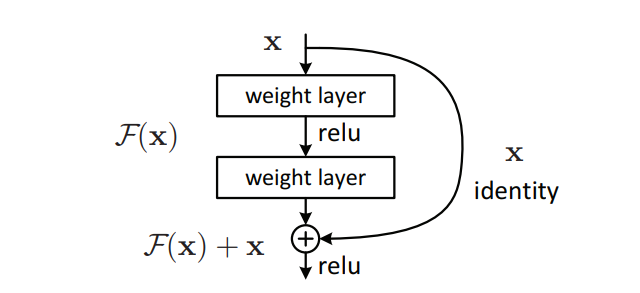

Training a ResNet would require too much time, however, we can use a Pre-trained ResNet and train an additional layer to classify its predictions.   
Therefore we can: 

1. Take a Pre-trained ResNet model and freeze its weights; 

In [37]:
# Pre trained Base model 
base_model = ResNet152(weights = 'imagenet', # pre trained imagnet weights
 include_top = False,
  input_shape = (100,100,3))

# freeze the weights for keeping the pretraiend ones 
for layer in base_model.layers:
    layer.trainable = False




234698864/234698864 [==============================] - 8s 0us/step


2. Transform the ouput of the base pre-trained model into a numerical vector in order to feed it to a custom dense output layer;

3. Train a dense output layer to classify the pre-trained model output, using dropout for controlling the overfitting; 

4. Train Prediction layer that return the classification.

In [38]:
# Take output of the pretrained model and convert it to 1d vector
x = layers.Flatten()(base_model.output)

# Feed the 1d vector to a fully connected layer
x = layers.Dense(1000, activation='relu')(x)

# Dropout to prevent overfitting
x = layers.Dropout(0.5)(x)

# Prediction Layer 
predictions = layers.Dense(2, activation = 'softmax')(x)

In [39]:
# our model take the input of the base model and return the output of the custom layer
head_model = Model(inputs = base_model.input,
 outputs = predictions)

# Compile
head_model.compile(optimizer='adam',
 loss=losses.categorical_crossentropy,
  metrics=['accuracy'])

In [40]:
history = head_model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10


80/80 [==============================] - 210s 3s/step - loss: 2.2480 - accuracy: 0.5135 - val_loss: 0.6890 - val_accuracy: 0.5102
Epoch 2/10
80/80 [==============================] - 199s 2s/step - loss: 0.6956 - accuracy: 0.5117 - val_loss: 0.6875 - val_accuracy: 0.5742
Epoch 3/10
80/80 [==============================] - 192s 2s/step - loss: 0.6887 - accuracy: 0.5340 - val_loss: 0.6867 - val_accuracy: 0.5281
Epoch 4/10
80/80 [==============================] - 191s 2s/step - loss: 0.6884 - accuracy: 0.5314 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 5/10
80/80 [==============================] - 195s 2s/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/10
80/80 [==============================] - 189s 2s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/10
80/80 [==============================] - 188s 2s/step - loss: 0.6933 - accuracy: 0.4895 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/10


In [41]:
histRN_=pd.DataFrame(history.history)
histRN_

loss  accuracy  val_loss  val_accuracy
0  2.248037  0.513477  0.688974      0.510156
1  0.695556  0.511719  0.687494      0.574219
2  0.688706  0.533984  0.686742      0.528125
3  0.688381  0.531445  0.693311      0.500000
4  0.693275  0.500000  0.693237      0.500000
5  0.693248  0.500000  0.693176      0.500000
6  0.693276  0.489453  0.693164      0.500000
7  0.693198  0.500000  0.693161      0.500000
8  0.693186  0.500000  0.693152      0.500000
9  0.693198  0.490234  0.693148      0.500000

From the table above we can notice that the accuracy for the validation set tends to sligthly increase at the beginning, but in the fourth epoch it stabilize at 50%.

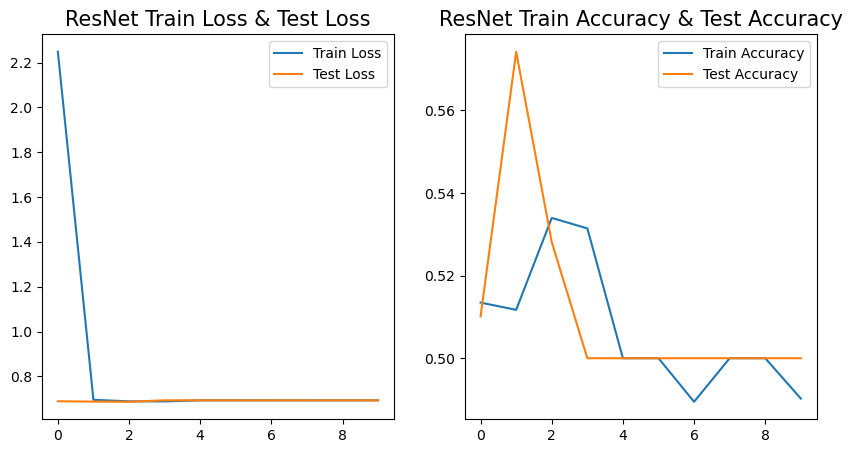

In [42]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(histRN_['loss'],label='Train Loss')
plt.plot(histRN_['val_loss'],label='Test Loss')
plt.title('ResNet Train Loss & Test Loss',fontsize=15)
plt.legend()
plt.subplot(1,2,2)
plt.plot(histRN_['accuracy'],label='Train Accuracy')
plt.plot(histRN_['val_accuracy'],label='Test Accuracy')
plt.title('ResNet Train Accuracy & Test Accuracy',fontsize=15)
plt.legend()
plt.show()

Here we are plotting both the loss and the accuracy in the training and validation sets. Talking about the loss we can easily see that in the validation set it remains always stable and in the training it has a deep decrease in the first epoch, and it stabilze after that. Looking an the accuracy we can see that in the training set it is really unstable during epochs, while in the validation it stabilize at epoch three.

In [43]:
scoreRN, accRN= head_model.evaluate(X_test,y_test)
print('Test Loss =', scoreRN)
print('Test Accuracy =', accRN)

40/40 [==============================] - 35s 826ms/step - loss: 0.6931 - accuracy: 0.5000
Test Loss = 0.6931476593017578
Test Accuracy = 0.5


In the cell above we can read the the final accuracy and loss that we reached in the validation set.

In [44]:
predictionsRN = head_model.predict(X_test)
y_pred = np.argmax(predictionsRN,axis=1)
y_test_ = np.argmax(y_test,axis=1)
dfRN = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
dfRN

40/40 [==============================] - 36s 853ms/step


Actual  Prediction
0          1           0
1          0           0
2          0           0
3          0           0
4          0           0
...      ...         ...
1275       0           0
1276       0           0
1277       0           0
1278       0           0
1279       1           0

[1280 rows x 2 columns]

This table shows for each observation in the validation set which prediction has been made.

array([[640,   0],
       [640,   0]], dtype=int64)

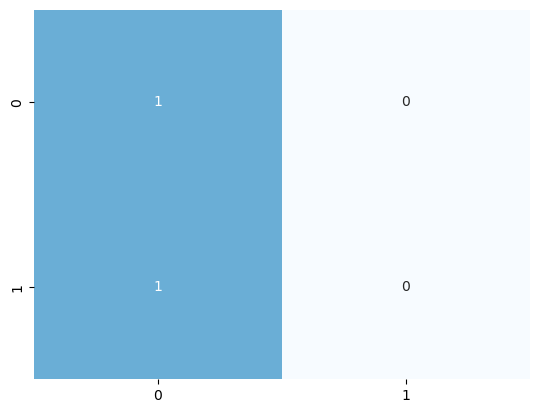

In [45]:
CMRN = confusion_matrix(y_test_,y_pred)
CM_percent = CMRN.astype('float') / CMRN.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CMRN

Looking at the confusion matrix we can see that this Neural network tend to classify correctly the sick people, while it misclassify all the healhy people.

In [46]:
ClassificationReportRN = classification_report(y_test_,y_pred)
print('ResNet Classification Report is : ', ClassificationReportRN )

ResNet Classification Report is :                precision    recall  f1-score   support

           0       0.50      1.00      0.67       640
           1       0.00      0.00      0.00       640

    accuracy                           0.50      1280
   macro avg       0.25      0.50      0.33      1280
weighted avg       0.25      0.50      0.33      1280



In this table we can see some statistics, but in this case they are not usefull at all.

We can conclude that this model is not able to separate the observations in the two classes.

### 3.3 VGG16

VGG stands for Visual Geometry Group, is a CNN compsoed of 16 layers.  

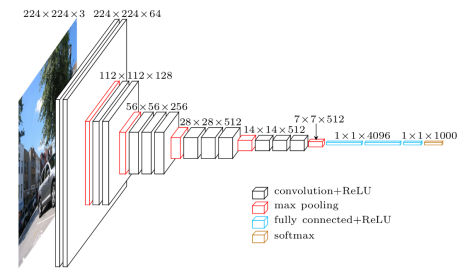


In [47]:
vgg16 = VGG16(weights='imagenet', input_shape=(100,100,3), include_top=False)

58889256/58889256 [==============================] - 2s 0us/step


In [48]:
for layer in vgg16.layers:
            layer.trainable = False

In [49]:
# Take output of the pretrained model and convert it to 1d vector
x = layers.Flatten()(vgg16.output)
# Feed the 1d vector to a fully connected layer
x = layers.Dense(256, activation='relu')(x)
# Dropout to prevent overfitting
x = layers.Dropout(0.5)(x)
# Prediction Layer 
predictions = layers.Dense(2,activation='softmax')(x)

# Compile merging base model with dense and output custom layers 
VGGmodel = Model(inputs=vgg16.input, outputs=predictions)
VGGmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [50]:
history = VGGmodel.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
80/80 [==============================] - 74s 913ms/step - loss: 0.6955 - accuracy: 0.6109 - val_loss: 0.6220 - val_accuracy: 0.6281
Epoch 2/10
80/80 [==============================] - 77s 962ms/step - loss: 0.6049 - accuracy: 0.6742 - val_loss: 0.5774 - val_accuracy: 0.7133
Epoch 3/10
80/80 [==============================] - 77s 968ms/step - loss: 0.5731 - accuracy: 0.6979 - val_loss: 0.5604 - val_accuracy: 0.7063
Epoch 4/10
80/80 [==============================] - 78s 984ms/step - loss: 0.5602 - accuracy: 0.7090 - val_loss: 0.5381 - val_accuracy: 0.7211
Epoch 5/10
80/80 [==============================] - 78s 972ms/step - loss: 0.5415 - accuracy: 0.7207 - val_loss: 0.5242 - val_accuracy: 0.7281
Epoch 6/10
80/80 [==============================] - 77s 964ms/step - loss: 0.5329 - accuracy: 0.7270 - val_loss: 0.5192 - val_accuracy: 0.7383
Epoch 7/10
80/80 [==============================] - 77s 968ms/step - loss: 0.5411 - accuracy: 0.7174 - val_loss: 0.5221 - val_accuracy: 0.7266

In [51]:
histVGG_=pd.DataFrame(history.history)
histVGG_

loss  accuracy  val_loss  val_accuracy
0  0.695472  0.610937  0.622042      0.628125
1  0.604878  0.674219  0.577381      0.713281
2  0.573105  0.697852  0.560384      0.706250
3  0.560233  0.708984  0.538105      0.721094
4  0.541490  0.720703  0.524247      0.728125
5  0.532854  0.726953  0.519181      0.738281
6  0.541087  0.717383  0.522150      0.726562
7  0.526485  0.738477  0.505710      0.746094
8  0.515532  0.735156  0.503606      0.742969
9  0.537016  0.729688  0.507035      0.740625

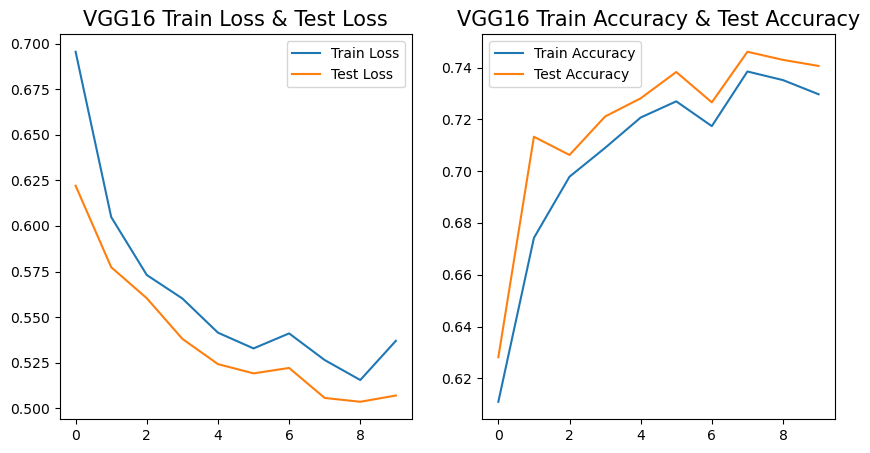

In [52]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(histVGG_['loss'],label='Train Loss')
plt.plot(histVGG_['val_loss'],label='Test Loss')
plt.title('VGG16 Train Loss & Test Loss',fontsize=15)
plt.legend()
plt.subplot(1,2,2)
plt.plot(histVGG_['accuracy'],label='Train Accuracy')
plt.plot(histVGG_['val_accuracy'],label='Test Accuracy')
plt.title('VGG16 Train Accuracy & Test Accuracy',fontsize=15)
plt.legend()
plt.show()

Looking at the table and the plots we can see that the training and testing loss tends to decrease during the epochs (just with a slight increse in the last epoch), while, if we look at the accuracy,both the sets tend to increase.

In [53]:
scoreVGG, accVGG= VGGmodel.evaluate(X_test,y_test)
print('Test Loss =', scoreVGG)
print('Test Accuracy =', accVGG)

40/40 [==============================] - 15s 380ms/step - loss: 0.5070 - accuracy: 0.7406
Test Loss = 0.5070348381996155
Test Accuracy = 0.7406250238418579


The final accuracy is 74%, that is way better than the one in the model above.

In [54]:
predictionsVGG = VGGmodel.predict(X_test)
y_pred = np.argmax(predictionsVGG,axis=1)
y_test_ = np.argmax(y_test,axis=1)
dfVGG = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
dfVGG

40/40 [==============================] - 16s 386ms/step


Actual  Prediction
0          1           1
1          0           0
2          0           0
3          0           0
4          0           0
...      ...         ...
1275       0           0
1276       0           0
1277       0           0
1278       0           0
1279       1           0

[1280 rows x 2 columns]

array([[471, 169],
       [163, 477]], dtype=int64)

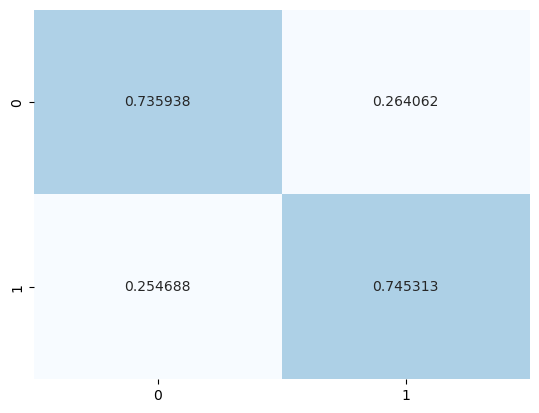

In [55]:
CMVGG = confusion_matrix(y_test_,y_pred)
CM_percent = CMVGG.astype('float') / CMVGG.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CMVGG

Looking at the confusion matrix we can't see anymore a clear misclassification trend, we see that both the categories are well classified.

In [56]:
ClassificationReportVGG = classification_report(y_test_,y_pred)
print(' VGG16 Classification Report is : ', ClassificationReportVGG )

 VGG16 Classification Report is :                precision    recall  f1-score   support

           0       0.74      0.74      0.74       640
           1       0.74      0.75      0.74       640

    accuracy                           0.74      1280
   macro avg       0.74      0.74      0.74      1280
weighted avg       0.74      0.74      0.74      1280



Even this table shows us that this model is doing better because both the precision and the racall are high in either sick and not sick individuals.

This model is way more appropriate than the previous one for the calssification of our data, and we are pretty satisfied about the results.

### 3.4 InceptionV3
Third version of a Google algorithm that uses:

- **Inception Modules**: blocks that performs convolutions of different sizes (1x1, 3x3, 5x5), as well as pooling operations, within the same layer.  
This allows the network to capture features at different spatial scales efficiently, with computation efficency due to using various small filters instead of large ones.  

- **Conncatenation Layers**: takes a list of tensors and concatenate them for making a single tensor.

- **Ausiliary Classifiers**: classifiers i nintermediate layers, separated from the output classifier that are used for enancing signal, avoiding vanishing gradient problem.
 

 


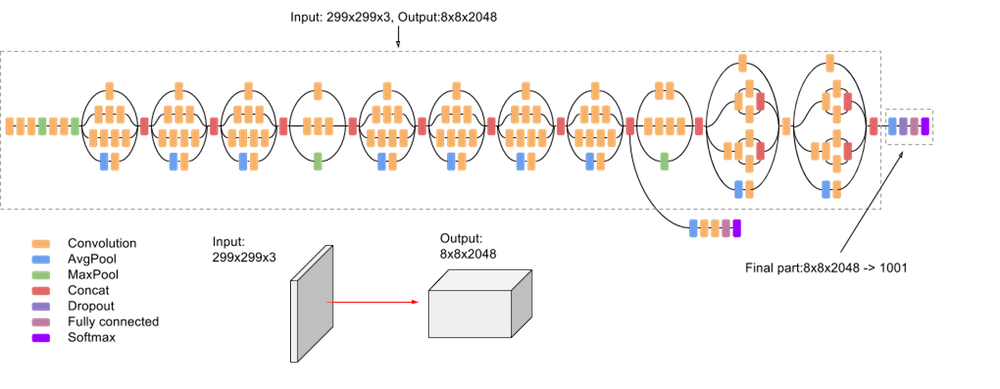

In [57]:
base_model = InceptionV3(weights='imagenet', include_top=False,input_shape=(100,100, 3))

87910968/87910968 [==============================] - 4s 0us/step


In [58]:
for layer in base_model.layers:
            layer.trainable = False

In [59]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)

predictions = layers.Dense(2,activation='softmax')(x)

V3model = Model(inputs=base_model.input, outputs=predictions)
V3model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [60]:
history = V3model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
80/80 [==============================] - 21s 212ms/step - loss: 1.2925 - accuracy: 0.6041 - val_loss: 0.6142 - val_accuracy: 0.6555
Epoch 2/10
80/80 [==============================] - 15s 190ms/step - loss: 0.5922 - accuracy: 0.6840 - val_loss: 0.5895 - val_accuracy: 0.6789
Epoch 3/10
80/80 [==============================] - 15s 192ms/step - loss: 0.5714 - accuracy: 0.6967 - val_loss: 0.5810 - val_accuracy: 0.6852
Epoch 4/10
80/80 [==============================] - 15s 189ms/step - loss: 0.5585 - accuracy: 0.7096 - val_loss: 0.5815 - val_accuracy: 0.6938
Epoch 5/10
80/80 [==============================] - 15s 190ms/step - loss: 0.5606 - accuracy: 0.7105 - val_loss: 0.5773 - val_accuracy: 0.6898
Epoch 6/10
80/80 [==============================] - 15s 191ms/step - loss: 0.5407 - accuracy: 0.7227 - val_loss: 0.5632 - val_accuracy: 0.6945
Epoch 7/10
80/80 [==============================] - 15s 192ms/step - loss: 0.5346 - accuracy: 0.7262 - val_loss: 0.5565 - val_accuracy: 0.7008

In [61]:
histV3_=pd.DataFrame(history.history)
histV3_

loss  accuracy  val_loss  val_accuracy
0  1.292452  0.604102  0.614192      0.655469
1  0.592179  0.683984  0.589506      0.678906
2  0.571432  0.696680  0.580977      0.685156
3  0.558457  0.709570  0.581529      0.693750
4  0.560552  0.710547  0.577321      0.689844
5  0.540725  0.722656  0.563204      0.694531
6  0.534603  0.726172  0.556452      0.700781
7  0.525340  0.737695  0.549075      0.702344
8  0.541511  0.718359  0.560953      0.685156
9  0.526917  0.732227  0.540052      0.705469

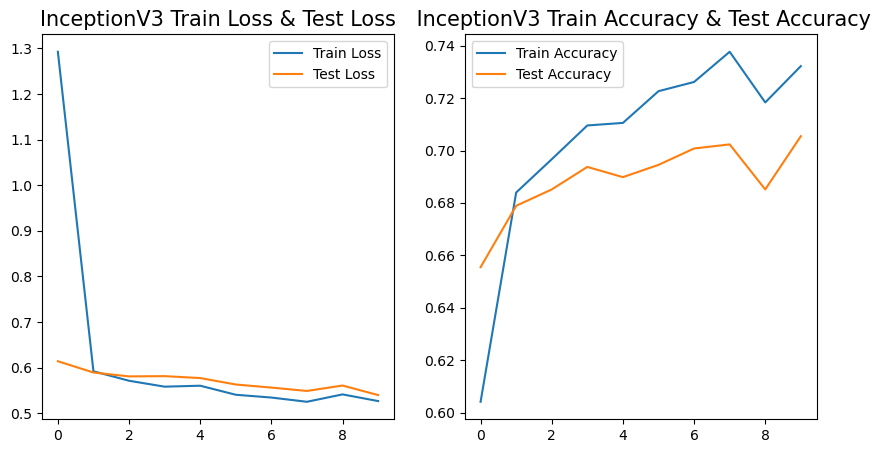

In [62]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(histV3_['loss'],label='Train Loss')
plt.plot(histV3_['val_loss'],label='Test Loss')
plt.title('InceptionV3 Train Loss & Test Loss',fontsize=15)
plt.legend()
plt.subplot(1,2,2)
plt.plot(histV3_['accuracy'],label='Train Accuracy')
plt.plot(histV3_['val_accuracy'],label='Test Accuracy')
plt.title(' InceptionV3 Train Accuracy & Test Accuracy',fontsize=15)
plt.legend()
plt.show()

In the table above and in the plots we notice that the loss decreases in the first epoch for the training set, and after slightly decreased, while for the validation set it always remained stable (with a decreasing trend). Talking about the accuracy, instead, we see that in the training set increses during epochs, and in validation it also ncrease but in a smoother way.

In [63]:
scoreV3, accV3= V3model.evaluate(X_test,y_test)
print('Test Loss =', scoreV3)
print('Test Accuracy =', accV3)

40/40 [==============================] - 6s 87ms/step - loss: 0.5401 - accuracy: 0.7055
Test Loss = 0.5400521159172058
Test Accuracy = 0.7054687738418579


At the end, we can see that the accuracy is lower then the one in the model above, but still pretty good.

In [64]:
predictionsV3 = V3model.predict(X_test)
y_pred = np.argmax(predictionsV3,axis=1)
y_test_ = np.argmax(y_test,axis=1)
dfV3 = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
dfV3

40/40 [==============================] - 4s 82ms/step


Actual  Prediction
0          1           1
1          0           0
2          0           0
3          0           0
4          0           0
...      ...         ...
1275       0           1
1276       0           0
1277       0           0
1278       0           0
1279       1           1

[1280 rows x 2 columns]

array([[431, 209],
       [168, 472]], dtype=int64)

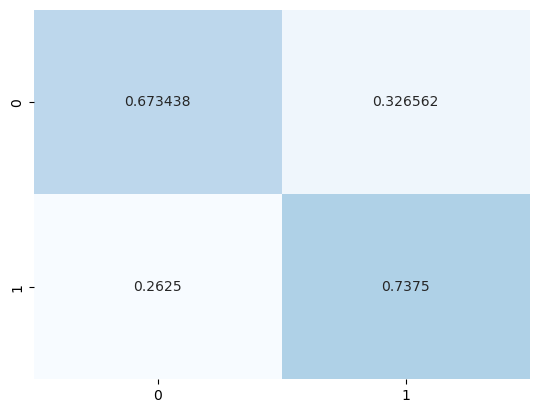

In [65]:
CMV3 = confusion_matrix(y_test_,y_pred)
CM_percent = CMV3.astype('float') / CMV3.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CMV3

From here, we can see that healthy people are better classified than sick, but in both cases the ecentage of miscalssification is not really high.

In [66]:
ClassificationReportV3 = classification_report(y_test_,y_pred)
print(' InceptionV3 Classification Report is : ', ClassificationReportV3 )

 InceptionV3 Classification Report is :                precision    recall  f1-score   support

           0       0.72      0.67      0.70       640
           1       0.69      0.74      0.71       640

    accuracy                           0.71      1280
   macro avg       0.71      0.71      0.71      1280
weighted avg       0.71      0.71      0.71      1280



To support this, we see that the precision of sick people is higher than the one of the healthy, while the recall goes in the opposite direction.

### 3.5 MobileNet

Architecture used for mobile devices artificial vision, developed for using as less computationally expensive as possible.  

It makes computations lighter by using:  
1. **Depthwise convolution** that applyes a different filter to each input channel obtaining C outputs;  

1. **Pointwise convolution** that combine each channel output using a 1x1 filter on them. 

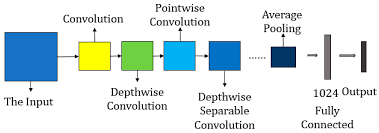

In [67]:
modelMN= MobileNet(weights='imagenet', include_top=False,input_shape=(100,100, 3))

17225924/17225924 [==============================] - 1s 0us/step


In [68]:
for layer in modelMN.layers:
            layer.trainable = False

In [69]:
x = layers.Flatten()(modelMN.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)

predictions = layers.Dense(2,activation='softmax')(x)

MNmodel = Model(inputs=modelMN.input, outputs=predictions)
MNmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [70]:
history = MNmodel.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
80/80 [==============================] - 25s 298ms/step - loss: 4.3337 - accuracy: 0.6283 - val_loss: 0.5370 - val_accuracy: 0.7320
Epoch 2/10
80/80 [==============================] - 22s 277ms/step - loss: 0.5421 - accuracy: 0.7219 - val_loss: 0.5023 - val_accuracy: 0.7586
Epoch 3/10
80/80 [==============================] - 22s 279ms/step - loss: 0.5172 - accuracy: 0.7295 - val_loss: 0.4946 - val_accuracy: 0.7578
Epoch 4/10
80/80 [==============================] - 22s 280ms/step - loss: 0.4839 - accuracy: 0.7613 - val_loss: 0.4807 - val_accuracy: 0.7664
Epoch 5/10
80/80 [==============================] - 22s 272ms/step - loss: 0.4475 - accuracy: 0.7879 - val_loss: 0.4706 - val_accuracy: 0.7742
Epoch 6/10
80/80 [==============================] - 23s 284ms/step - loss: 0.4474 - accuracy: 0.7824 - val_loss: 0.4472 - val_accuracy: 0.7781
Epoch 7/10
80/80 [==============================] - 22s 277ms/step - loss: 0.4421 - accuracy: 0.7885 - val_loss: 0.4747 - val_accuracy: 0.7547

In [71]:
histMN_=pd.DataFrame(history.history)
histMN_

loss  accuracy  val_loss  val_accuracy
0  4.333732  0.628320  0.537020      0.732031
1  0.542069  0.721875  0.502300      0.758594
2  0.517213  0.729492  0.494598      0.757812
3  0.483855  0.761328  0.480699      0.766406
4  0.447510  0.787891  0.470555      0.774219
5  0.447431  0.782422  0.447184      0.778125
6  0.442075  0.788477  0.474714      0.754687
7  0.432381  0.789258  0.527407      0.731250
8  0.436121  0.790625  0.422848      0.788281
9  0.394077  0.813477  0.384410      0.830469

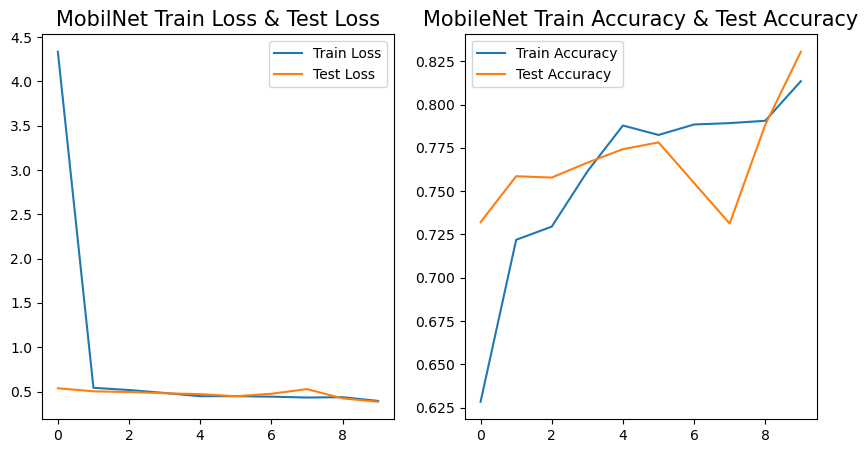

In [72]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(histMN_['loss'],label='Train Loss')
plt.plot(histMN_['val_loss'],label='Test Loss')
plt.title('MobilNet Train Loss & Test Loss',fontsize=15)
plt.legend()
plt.subplot(1,2,2)
plt.plot(histMN_['accuracy'],label='Train Accuracy')
plt.plot(histMN_['val_accuracy'],label='Test Accuracy')
plt.title('MobileNet Train Accuracy & Test Accuracy',fontsize=15)
plt.legend()
plt.show()

Table and plot show that this model works pretty fine on our data. The loss tend to have a slight decrease during epochs in both training (after the steep decrease of the first epoch) and validation, while accuracy increases a lot in the training set. For the validation one it has a lower peak in epoch 7, but after it increase very steeply.

In [73]:
scoreMN, accMN= MNmodel.evaluate(X_test,y_test)
print('Test Loss =', scoreMN)
print('Test Accuracy =', accMN)

40/40 [==============================] - 3s 72ms/step - loss: 0.3844 - accuracy: 0.8305
Test Loss = 0.384409636259079
Test Accuracy = 0.8304687738418579


The final accuracy is the best, for the moment, and even the loss is the lowest we had.

In [74]:
predictionsMN = MNmodel.predict(X_test)
y_pred = np.argmax(predictionsMN,axis=1)
y_test_ = np.argmax(y_test,axis=1)
dfMN = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
dfMN

40/40 [==============================] - 3s 77ms/step


Actual  Prediction
0          1           1
1          0           0
2          0           0
3          0           0
4          0           0
...      ...         ...
1275       0           0
1276       0           0
1277       0           0
1278       0           0
1279       1           0

[1280 rows x 2 columns]

array([[536, 104],
       [113, 527]], dtype=int64)

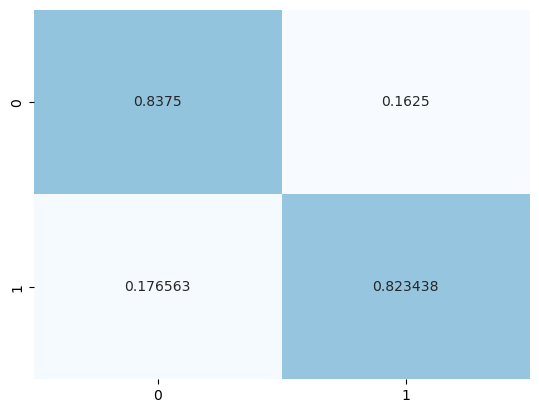

In [75]:
CMMN = confusion_matrix(y_test_,y_pred)
CM_percent = CMMN.astype('float') / CMMN.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CMMN

The confusion matrix is really convincing, the two classes are balanced and cathegorized well.

In [76]:
ClassificationReportMN = classification_report(y_test_,y_pred)
print(' MobileNet Classification Report is : ', ClassificationReportMN )

 MobileNet Classification Report is :                precision    recall  f1-score   support

           0       0.83      0.84      0.83       640
           1       0.84      0.82      0.83       640

    accuracy                           0.83      1280
   macro avg       0.83      0.83      0.83      1280
weighted avg       0.83      0.83      0.83      1280



The precision and the recall in the classes is really similar and high, so we are really happy about our model.

### 3.6 EfficentNet

CNN that uniformly scales network width, depth, and resolution using a **compounding scale** that fixes all the three dimensions according to a predefined ratio.  

This permit to control Network size and computational cost varying just one coefficent, the compounding coefficent ϕ.
- Increase **Width** lead to more channels per layer so more diverse features;
- Increase **Depth** permit to capture more ocmplex relations; 
- Increase **Resolution** gives more detailed informations.

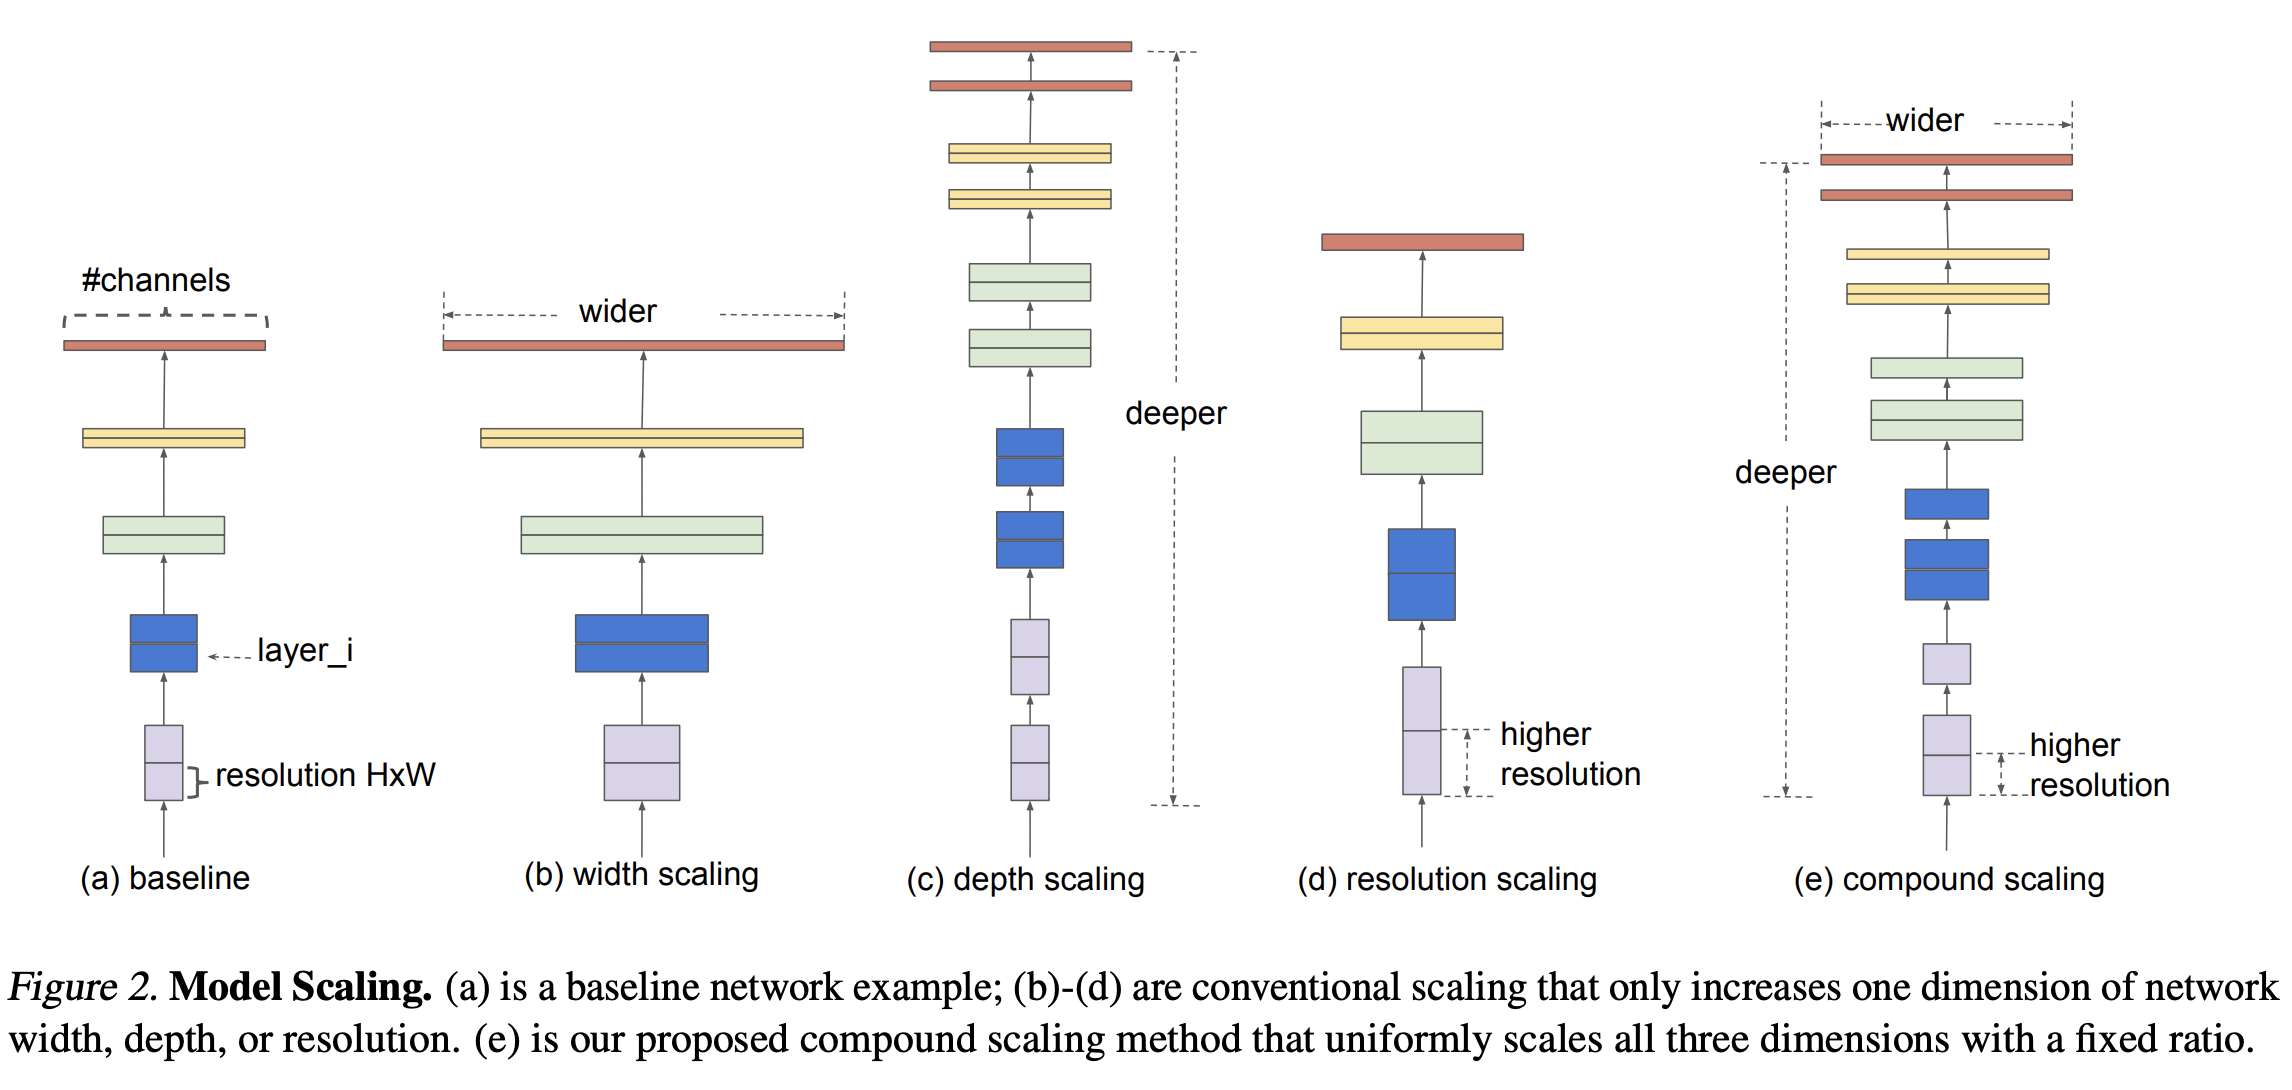

In [77]:
modelEN = EfficientNetB0(weights='imagenet', include_top=False,input_shape=(100,100, 3))

16705208/16705208 [==============================] - 1s 0us/step


In [78]:
for layer in modelEN.layers:
            layer.trainable = False

In [79]:
x = layers.Flatten()(modelEN.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)

predictions = layers.Dense(2,activation='softmax')(x)

ENmodel = Model(inputs=modelEN.input, outputs=predictions)
ENmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [80]:
history = ENmodel.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
80/80 [==============================] - 54s 611ms/step - loss: 1.7926 - accuracy: 0.4867 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/10
80/80 [==============================] - 46s 581ms/step - loss: 0.6958 - accuracy: 0.4896 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/10
80/80 [==============================] - 46s 573ms/step - loss: 0.6965 - accuracy: 0.5018 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/10
80/80 [==============================] - 46s 577ms/step - loss: 0.6940 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/10
80/80 [==============================] - 46s 582ms/step - loss: 0.6941 - accuracy: 0.4922 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/10
80/80 [==============================] - 46s 572ms/step - loss: 0.6932 - accuracy: 0.4965 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/10
80/80 [==============================] - 46s 576ms/step - loss: 0.6932 - accuracy: 0.4953 - val_loss: 0.6931 - val_accuracy: 0.5000

In [81]:
histEN_=pd.DataFrame(history.history)
histEN_

loss  accuracy  val_loss  val_accuracy
0  1.792630  0.486719  0.693177           0.5
1  0.695831  0.489648  0.693148           0.5
2  0.696521  0.501758  0.693151           0.5
3  0.693953  0.500000  0.693149           0.5
4  0.694113  0.492188  0.693148           0.5
5  0.693172  0.496484  0.693147           0.5
6  0.693233  0.495313  0.693148           0.5
7  0.693959  0.501172  0.693158           0.5
8  0.693166  0.500000  0.693149           0.5
9  0.693602  0.491211  0.693148           0.5

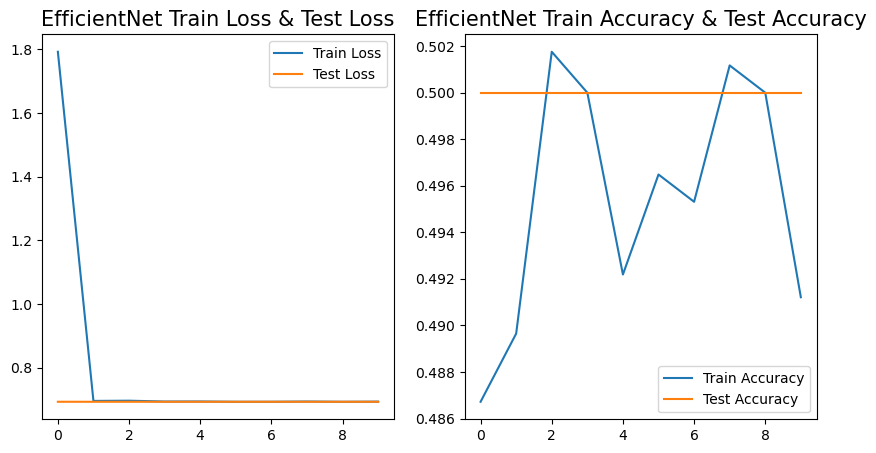

In [82]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(histEN_['loss'],label='Train Loss')
plt.plot(histEN_['val_loss'],label='Test Loss')
plt.title('EfficientNet Train Loss & Test Loss',fontsize=15)
plt.legend()
plt.subplot(1,2,2)
plt.plot(histEN_['accuracy'],label='Train Accuracy')
plt.plot(histEN_['val_accuracy'],label='Test Accuracy')
plt.title('EfficientNet Train Accuracy & Test Accuracy',fontsize=15)
plt.legend()
plt.show()

Looking at the accuracy, it is easy to see that this model works really badly on our data, since it is really instable for the training set, and always equal to 50% in the validation.
The shape of the loss function is similar to the one in the other models, even if it stabilize at a really high level.

In [83]:
scoreEN, accEN= ENmodel.evaluate(X_test,y_test)
print('Test Loss =', scoreEN)
print('Test Accuracy =', accEN)

40/40 [==============================] - 8s 159ms/step - loss: 0.6931 - accuracy: 0.5000
Test Loss = 0.6931484341621399
Test Accuracy = 0.5


In [84]:
predictionsEN = ENmodel.predict(X_test)
y_pred = np.argmax(predictionsEN,axis=1)
y_test_ = np.argmax(y_test,axis=1)
dfEN = pd.DataFrame({'Actual': y_test_, 'Prediction': y_pred})
dfEN

40/40 [==============================] - 8s 144ms/step


Actual  Prediction
0          1           1
1          0           1
2          0           1
3          0           1
4          0           1
...      ...         ...
1275       0           1
1276       0           1
1277       0           1
1278       0           1
1279       1           1

[1280 rows x 2 columns]

array([[  0, 640],
       [  0, 640]], dtype=int64)

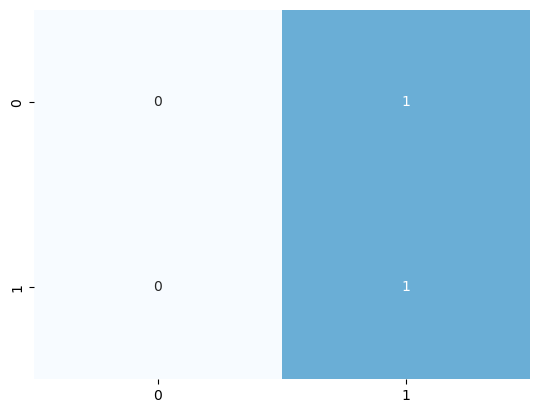

In [85]:
CMEN = confusion_matrix(y_test_,y_pred)
CM_percent = CMEN.astype('float') / CMEN.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CMEN

Looking at the matrix we can easily understand why the accuracy is that low: the model is not able to see the two classes in the images and it classify all of them as healthy people.

In [86]:
ClassificationReportEN = classification_report(y_test_,y_pred)
print(' EfficientNet Classification Report is : ', ClassificationReportEN )

 EfficientNet Classification Report is :                precision    recall  f1-score   support

           0       0.00      0.00      0.00       640
           1       0.50      1.00      0.67       640

    accuracy                           0.50      1280
   macro avg       0.25      0.50      0.33      1280
weighted avg       0.25      0.50      0.33      1280



In this circumstance, this table is not usefull at all.

## 4- CNN with data augmentation

To try to improve our models, we can take all 6400 images but apply a data augmentation that slightly modifies them to better train the CNNs.
In this part we will use the exact same methods as before, in order to see if we can get more accurate results.

### 4.1 Splitting data

As before we use ImageDataGenerator() and flow_from_dataframe() to read images as tensors.

In [164]:
Size1=(100,100)

work_dr1 = ImageDataGenerator(rescale = 1./255)     

data_gen1 = work_dr1.flow_from_dataframe(df,
x_col='image',
y_col='label',
 target_size=Size1,
  batch_size=3000,
   shuffle=False)


Found 6400 validated image filenames belonging to 4 classes.


Unfortunately we can't use all the data we managed to have because it would be too heavy for our machines to handle.

In [165]:
# check next batch 
new_data1, new_labels1 = data_gen1.next()
# order the labels
class_num1=np.sort(['MildDemented','ModerateDemented','NonDemented','VeryMildDemented'])
class_num1

array(['MildDemented', 'ModerateDemented', 'NonDemented',
       'VeryMildDemented'], dtype='<U16')

To apply data augmentation, however, this time we define the **SMOOTE** (Synthetic Minority Oversampling Technique) transformation that generates augmented images of minority classes to balance the dataset.

We can then **keep all 4 classes** by balancing them with data augmentation to see if the algorithms improve. 



In [166]:
sm = SMOTE(random_state=42)
new_data1, new_labels1 = sm.fit_resample(new_data1.reshape(-1, 100 * 100 * 3), new_labels1)
new_data1 = new_data1.reshape(-1, 100,100, 3)
print(new_data1.shape, new_labels1.shape)

(6368, 100, 100, 3) (6368, 4)


In [167]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(new_data1,new_labels1, test_size=0.2, random_state=42,shuffle=True,stratify=new_labels1)

print('X_train1 shape is ' , X_train1.shape)
print('X_test1 shape is ' , X_test1.shape)
print('y_train1 shape is ' , y_train1.shape)
print('y_test1 shape is ' , y_test1.shape)

X_train1 shape is  (5094, 100, 100, 3)
X_test1 shape is  (1274, 100, 100, 3)
y_train1 shape is  (5094, 4)
y_test1 shape is  (1274, 4)


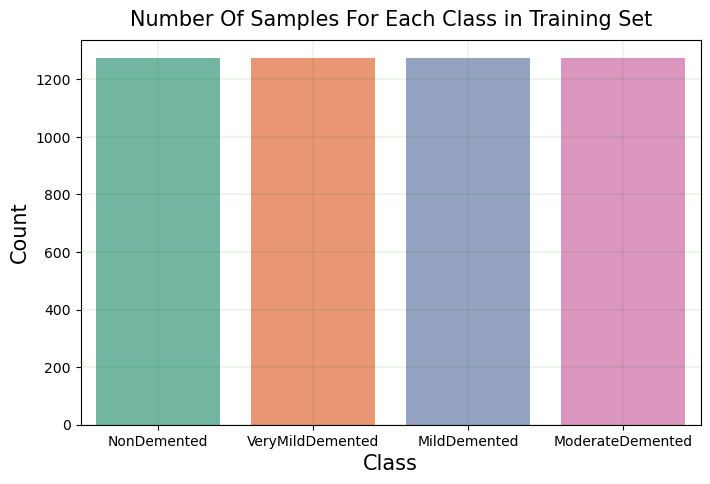

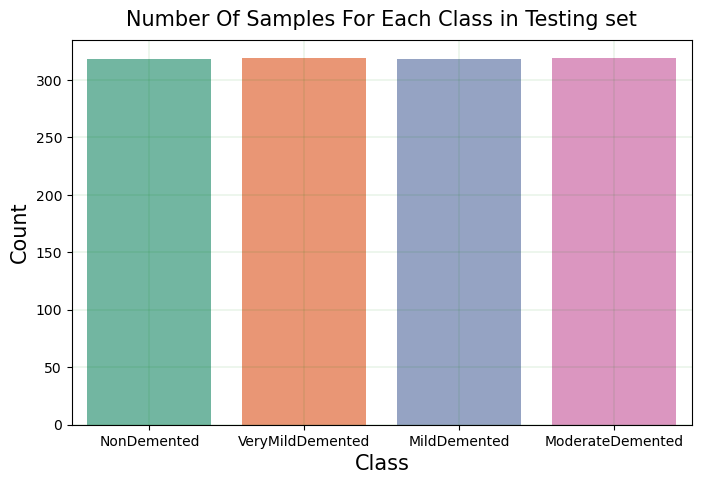

In [168]:
labels1=[class_num1[i] for i in np.argmax(y_train1,axis=1) ]
plt.figure(figsize=(8,5))
ax = sns.countplot(x=labels1,order= ['NonDemented','VeryMildDemented','MildDemented','ModerateDemented'], palette="Set2")
ax.set_xlabel("Class",fontsize=15)
ax.set_ylabel("Count",fontsize=15)
plt.title('Number Of Samples For Each Class in Training Set',fontsize=15, pad= 10)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

labels1=[class_num1[i] for i in np.argmax(y_test1,axis=1) ]
plt.figure(figsize=(8,5))
ax = sns.countplot(x=labels1,order= ['NonDemented','VeryMildDemented','MildDemented','ModerateDemented'], palette="Set2")
ax.set_xlabel("Class",fontsize=15)
ax.set_ylabel("Count",fontsize=15)
plt.title('Number Of Samples For Each Class in Testing set',fontsize=15, pad= 10)
plt.grid(color='g', linestyle='-', linewidth=0.1)
plt.show()

### 4.2 ResNet

In [169]:
base_model1 = ResNet152(weights = 'imagenet', include_top = False, input_shape = (100,100,3))
for layer1 in base_model1.layers:
    layer1.trainable = False

In [170]:
x = layers.Flatten()(base_model1.output)
x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions1 = layers.Dense(4, activation = 'softmax')(x)

In [171]:
head_model1 = Model(inputs = base_model1.input, outputs = predictions1)
head_model1.compile(optimizer='adam', loss=losses.categorical_crossentropy, metrics=['accuracy'])

In [172]:
history1 = head_model1.fit(X_train1, y_train1, batch_size=64, epochs=10, validation_data=(X_test1, y_test1))

Epoch 1/10
80/80 [==============================] - 204s 2s/step - loss: 5.3800 - accuracy: 0.3589 - val_loss: 1.2138 - val_accuracy: 0.4027
Epoch 2/10
80/80 [==============================] - 187s 2s/step - loss: 1.2367 - accuracy: 0.4036 - val_loss: 1.1563 - val_accuracy: 0.5039
Epoch 3/10
80/80 [==============================] - 187s 2s/step - loss: 1.2073 - accuracy: 0.4217 - val_loss: 1.1110 - val_accuracy: 0.5338
Epoch 4/10
80/80 [==============================] - 189s 2s/step - loss: 1.1623 - accuracy: 0.4331 - val_loss: 1.1091 - val_accuracy: 0.5173
Epoch 5/10
80/80 [==============================] - 188s 2s/step - loss: 1.1552 - accuracy: 0.4543 - val_loss: 1.1213 - val_accuracy: 0.5534
Epoch 6/10
80/80 [==============================] - 191s 2s/step - loss: 1.1651 - accuracy: 0.4654 - val_loss: 1.0124 - val_accuracy: 0.6107
Epoch 7/10
80/80 [==============================] - 188s 2s/step - loss: 1.1472 - accuracy: 0.4735 - val_loss: 1.0218 - val_accuracy: 0.6468
Epoch 8/10
80

In [173]:
histRN1_=pd.DataFrame(history1.history)
histRN1_

loss  accuracy  val_loss  val_accuracy
0  5.379953  0.358854  1.213782      0.402669
1  1.236723  0.403612  1.156345      0.503925
2  1.207267  0.421673  1.111010      0.533752
3  1.162287  0.433059  1.109095      0.517268
4  1.155158  0.454260  1.121269      0.553375
5  1.165130  0.465450  1.012440      0.610675
6  1.147177  0.473498  1.021823      0.646782
7  1.173224  0.432470  1.011873      0.638148
8  1.148614  0.454849  1.086555      0.568289
9  1.154582  0.444641  0.957166      0.679749

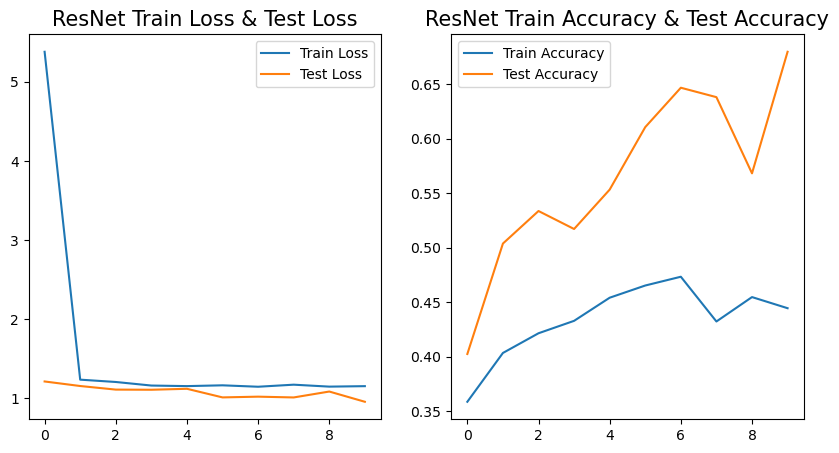

In [174]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(histRN1_['loss'],label='Train Loss')
plt.plot(histRN1_['val_loss'],label='Test Loss')
plt.title('ResNet Train Loss & Test Loss',fontsize=15)
plt.legend()
plt.subplot(1,2,2)
plt.plot(histRN1_['accuracy'],label='Train Accuracy')
plt.plot(histRN1_['val_accuracy'],label='Test Accuracy')
plt.title('ResNet Train Accuracy & Test Accuracy',fontsize=15)
plt.legend()
plt.show()

The shape of the loss function is really similar to the previous ones, while for the accuracy we see that it works way better in the validation set, then in the training one. In both of them it tends to increase over epochs.

In [175]:
scoreRN1, accRN1= head_model1.evaluate(X_test1,y_test1)
print('Test Loss =', scoreRN1)
print('Test Accuracy =', accRN1)

40/40 [==============================] - 33s 823ms/step - loss: 0.9572 - accuracy: 0.6797
Test Loss = 0.9571656584739685
Test Accuracy = 0.6797488331794739


The final accuarcy is 68% that is not really bad, but the loss is almost 96% that is huge.

In [176]:
predictionsRN1 = head_model1.predict(X_test1)
y_pred1 = np.argmax(predictionsRN1,axis=1)
y_test1_ = np.argmax(y_test1,axis=1)
dfRN1 = pd.DataFrame({'Actual': y_test1_, 'Prediction': y_pred1})
dfRN1

40/40 [==============================] - 35s 822ms/step


Actual  Prediction
0          2           0
1          3           3
2          3           3
3          1           1
4          2           3
...      ...         ...
1269       0           2
1270       2           2
1271       0           1
1272       2           2
1273       3           3

[1274 rows x 2 columns]

array([[ 84,  91,  82,  61],
       [  7, 311,   0,   1],
       [ 29,  24, 176,  89],
       [  2,  10,  12, 295]], dtype=int64)

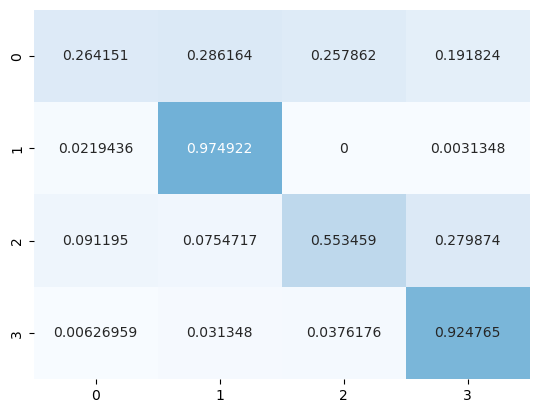

In [177]:
CMRN1 = confusion_matrix(y_test1_,y_pred1)
CM_percent1 = CMRN1.astype('float') / CMRN1.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent1,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CMRN1

We can see that some classes are really accurately splitted, while the Not Demented are not abe to be recognised.

In [178]:
ClassificationReportRN1 = classification_report(y_test1_,y_pred1)
print('ResNet Classification Report is : ', ClassificationReportRN1 )

ResNet Classification Report is :                precision    recall  f1-score   support

           0       0.69      0.26      0.38       318
           1       0.71      0.97      0.82       319
           2       0.65      0.55      0.60       318
           3       0.66      0.92      0.77       319

    accuracy                           0.68      1274
   macro avg       0.68      0.68      0.64      1274
weighted avg       0.68      0.68      0.64      1274



Looking at the precision and recall the model does not seem really bad, but we hope to have models that work better.

### 4.3 VGG16

In [179]:
vgg161 = VGG16(weights='imagenet', input_shape=(100,100,3), include_top=False)

In [180]:
for layer1 in vgg161.layers:
            layer1.trainable = False

In [181]:
x = layers.Flatten()(vgg161.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions1 = layers.Dense(4,activation='softmax')(x)

VGGmodel1 = Model(inputs=vgg161.input, outputs=predictions1)
VGGmodel1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [182]:
history1 = VGGmodel1.fit(X_train1, y_train1, batch_size=64, epochs=10, validation_data=(X_test1, y_test1))

Epoch 1/10
80/80 [==============================] - 75s 927ms/step - loss: 1.0789 - accuracy: 0.5406 - val_loss: 0.7192 - val_accuracy: 0.7732
Epoch 2/10
80/80 [==============================] - 75s 940ms/step - loss: 0.7123 - accuracy: 0.7311 - val_loss: 0.5697 - val_accuracy: 0.7802
Epoch 3/10
80/80 [==============================] - 75s 941ms/step - loss: 0.5829 - accuracy: 0.7764 - val_loss: 0.5210 - val_accuracy: 0.7959
Epoch 4/10
80/80 [==============================] - 75s 938ms/step - loss: 0.5149 - accuracy: 0.8002 - val_loss: 0.4142 - val_accuracy: 0.8485
Epoch 5/10
80/80 [==============================] - 74s 933ms/step - loss: 0.4519 - accuracy: 0.8176 - val_loss: 0.3641 - val_accuracy: 0.8626
Epoch 6/10
80/80 [==============================] - 77s 961ms/step - loss: 0.4233 - accuracy: 0.8420 - val_loss: 0.3356 - val_accuracy: 0.8713
Epoch 7/10
80/80 [==============================] - 75s 939ms/step - loss: 0.3911 - accuracy: 0.8439 - val_loss: 0.3204 - val_accuracy: 0.8783

In [183]:
histVGG1_=pd.DataFrame(history1.history)
histVGG1_

loss  accuracy  val_loss  val_accuracy
0  1.078900  0.540636  0.719218      0.773155
1  0.712268  0.731056  0.569715      0.780220
2  0.582872  0.776404  0.521019      0.795918
3  0.514881  0.800157  0.414241      0.848509
4  0.451934  0.817629  0.364104      0.862637
5  0.423314  0.841971  0.335575      0.871272
6  0.391142  0.843934  0.320369      0.878336
7  0.371053  0.854535  0.306472      0.885400
8  0.346497  0.863565  0.293800      0.893250
9  0.343883  0.862976  0.290366      0.905808

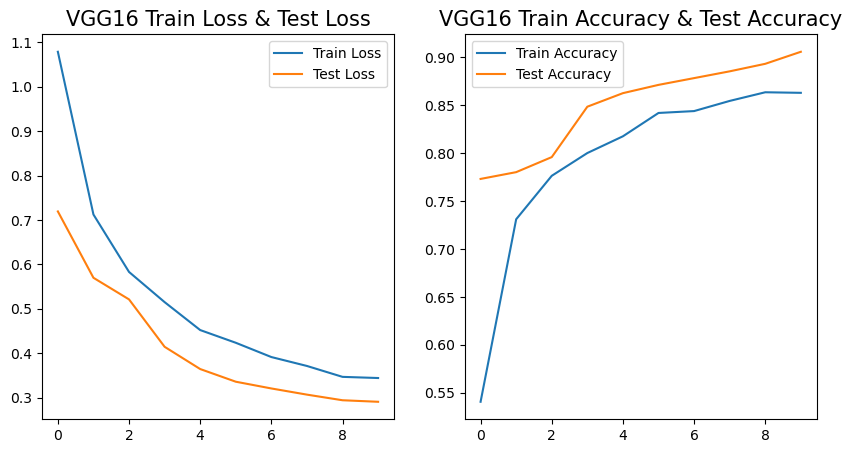

In [184]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(histVGG1_['loss'],label='Train Loss')
plt.plot(histVGG1_['val_loss'],label='Test Loss')
plt.title('VGG16 Train Loss & Test Loss',fontsize=15)
plt.legend()
plt.subplot(1,2,2)
plt.plot(histVGG1_['accuracy'],label='Train Accuracy')
plt.plot(histVGG1_['val_accuracy'],label='Test Accuracy')
plt.title('VGG16 Train Accuracy & Test Accuracy',fontsize=15)
plt.legend()
plt.show()

This model is way better then the one before, the loss decreases in the epochs and the accuracy increases, with the one of the validation set that is higher then the one in the testing.

In [185]:
scoreVGG1, accVGG1= VGGmodel1.evaluate(X_test1,y_test1)
print('Test Loss =', scoreVGG1)
print('Test Accuracy =', accVGG1)

40/40 [==============================] - 17s 414ms/step - loss: 0.2904 - accuracy: 0.9058
Test Loss = 0.29036566615104675
Test Accuracy = 0.9058084487915039


The accuarcy reaches 90%, that is an amazing result. The loss is also really low.

In [186]:
predictionsVGG1 = VGGmodel1.predict(X_test1)
y_pred1 = np.argmax(predictionsVGG1,axis=1)
y_test1_ = np.argmax(y_test1,axis=1)
dfVGG1 = pd.DataFrame({'Actual': y_test1_, 'Prediction': y_pred1})
dfVGG1

40/40 [==============================] - 16s 395ms/step


Actual  Prediction
0          2           2
1          3           3
2          3           3
3          1           1
4          2           2
...      ...         ...
1269       0           0
1270       2           2
1271       0           0
1272       2           2
1273       3           3

[1274 rows x 2 columns]

array([[282,   0,  24,  12],
       [  0, 319,   0,   0],
       [ 34,   0, 258,  26],
       [  5,   0,  19, 295]], dtype=int64)

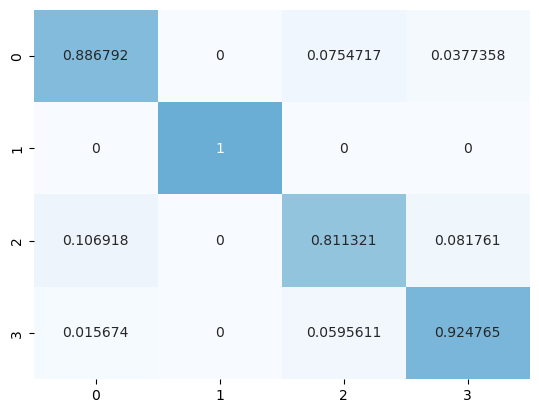

In [187]:
CMVGG1 = confusion_matrix(y_test1_,y_pred1)
CM_percent1 = CMVGG1.astype('float') / CMVGG1.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent1,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CMVGG1

In [188]:
ClassificationReportVGG1 = classification_report(y_test1_,y_pred1)
print(' VGG16 Classification Report is : ', ClassificationReportVGG1 )

 VGG16 Classification Report is :                precision    recall  f1-score   support

           0       0.88      0.89      0.88       318
           1       1.00      1.00      1.00       319
           2       0.86      0.81      0.83       318
           3       0.89      0.92      0.90       319

    accuracy                           0.91      1274
   macro avg       0.91      0.91      0.91      1274
weighted avg       0.91      0.91      0.91      1274



We can easily see that this model works really well on our data, and categorize them almost perfectly.

### 4.4 InceptionV3

In [189]:
base_model1 = InceptionV3(weights='imagenet', include_top=False,input_shape=(100,100, 3))

In [190]:
for layer1 in base_model1.layers:
            layer1.trainable = False

In [191]:
x = layers.Flatten()(base_model1.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)

predictions1 = layers.Dense(4,activation='softmax')(x)

V3model1 = Model(inputs=base_model1.input, outputs=predictions1)
V3model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [192]:
history1 = V3model1.fit(X_train1, y_train1, batch_size=64, epochs=10, validation_data=(X_test1, y_test1))

Epoch 1/10
80/80 [==============================] - 20s 209ms/step - loss: 1.3183 - accuracy: 0.5834 - val_loss: 0.6850 - val_accuracy: 0.7245
Epoch 2/10
80/80 [==============================] - 16s 196ms/step - loss: 0.6709 - accuracy: 0.7297 - val_loss: 0.5260 - val_accuracy: 0.7881
Epoch 3/10
80/80 [==============================] - 15s 191ms/step - loss: 0.5376 - accuracy: 0.7860 - val_loss: 0.4740 - val_accuracy: 0.8014
Epoch 4/10
80/80 [==============================] - 15s 191ms/step - loss: 0.5037 - accuracy: 0.7954 - val_loss: 0.4389 - val_accuracy: 0.8218
Epoch 5/10
80/80 [==============================] - 16s 199ms/step - loss: 0.4769 - accuracy: 0.8074 - val_loss: 0.4024 - val_accuracy: 0.8469
Epoch 6/10
80/80 [==============================] - 16s 197ms/step - loss: 0.4276 - accuracy: 0.8253 - val_loss: 0.3613 - val_accuracy: 0.8462
Epoch 7/10
80/80 [==============================] - 16s 198ms/step - loss: 0.4000 - accuracy: 0.8377 - val_loss: 0.3929 - val_accuracy: 0.8344

In [193]:
histV31_=pd.DataFrame(history1.history)
histV31_

loss  accuracy  val_loss  val_accuracy
0  1.318324  0.583431  0.685030      0.724490
1  0.670898  0.729682  0.526039      0.788069
2  0.537565  0.786023  0.474033      0.801413
3  0.503664  0.795446  0.438930      0.821821
4  0.476867  0.807420  0.402446      0.846939
5  0.427646  0.825285  0.361322      0.846154
6  0.399974  0.837652  0.392904      0.834380
7  0.402956  0.837063  0.382951      0.833595
8  0.364785  0.851197  0.319944      0.865777
9  0.354774  0.858854  0.312197      0.869702

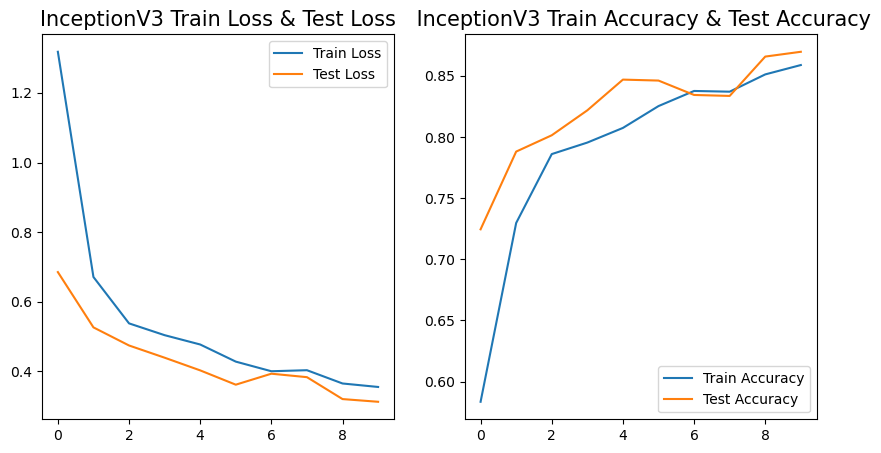

In [194]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(histV31_['loss'],label='Train Loss')
plt.plot(histV31_['val_loss'],label='Test Loss')
plt.title('InceptionV3 Train Loss & Test Loss',fontsize=15)
plt.legend()
plt.subplot(1,2,2)
plt.plot(histV31_['accuracy'],label='Train Accuracy')
plt.plot(histV31_['val_accuracy'],label='Test Accuracy')
plt.title(' InceptionV3 Train Accuracy & Test Accuracy',fontsize=15)
plt.legend()
plt.show()

Even this model is really good, with a shape really similar to the one above.

In [195]:
scoreV31, accV31= V3model1.evaluate(X_test1,y_test1)
print('Test Loss =', scoreV31)
print('Test Accuracy =', accV31)

40/40 [==============================] - 3s 83ms/step - loss: 0.3122 - accuracy: 0.8697
Test Loss = 0.31219711899757385
Test Accuracy = 0.8697017431259155


This model is a bit worse then the one above, even if it is still surprisigly good.

In [196]:
predictionsV31 = V3model1.predict(X_test1)
y_pred1 = np.argmax(predictionsV31,axis=1)
y_test1_ = np.argmax(y_test1,axis=1)
dfV31 = pd.DataFrame({'Actual': y_test1_, 'Prediction': y_pred1})
dfV31

40/40 [==============================] - 4s 83ms/step


Actual  Prediction
0          2           0
1          3           3
2          3           3
3          1           1
4          2           3
...      ...         ...
1269       0           0
1270       2           2
1271       0           0
1272       2           2
1273       3           1

[1274 rows x 2 columns]

array([[269,   1,  23,  25],
       [  1, 318,   0,   0],
       [ 47,   0, 228,  43],
       [  4,   1,  21, 293]], dtype=int64)

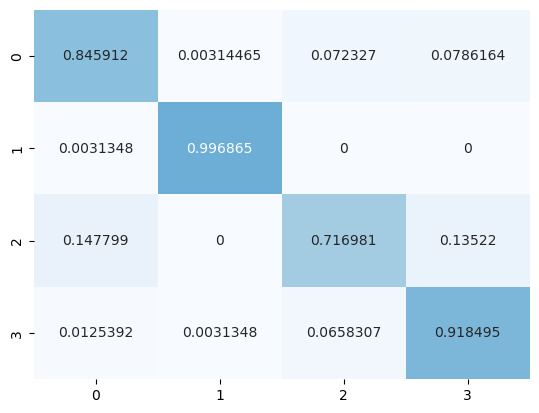

In [197]:
CMV31 = confusion_matrix(y_test1_,y_pred1)
CM_percent1 = CMV31.astype('float') / CMV31.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent1,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CMV31

In [198]:
ClassificationReportV31 = classification_report(y_test1_,y_pred1)
print(' InceptionV3 Classification Report is : ', ClassificationReportV31 )

 InceptionV3 Classification Report is :                precision    recall  f1-score   support

           0       0.84      0.85      0.84       318
           1       0.99      1.00      1.00       319
           2       0.84      0.72      0.77       318
           3       0.81      0.92      0.86       319

    accuracy                           0.87      1274
   macro avg       0.87      0.87      0.87      1274
weighted avg       0.87      0.87      0.87      1274



We can see that the confusion matrix is really similar to the previous model one.

### 4.5 MobileNet

In [199]:
modelMN1= MobileNet(weights='imagenet', include_top=False,input_shape=(100,100, 3))

In [200]:
for layer1 in modelMN1.layers:
            layer1.trainable = False

In [201]:
x = layers.Flatten()(modelMN1.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)

predictions1 = layers.Dense(4,activation='softmax')(x)

MNmodel1 = Model(inputs=modelMN1.input, outputs=predictions1)
MNmodel1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [202]:
history1 = MNmodel1.fit(X_train1, y_train1, batch_size=64, epochs=10, validation_data=(X_test1, y_test1))

Epoch 1/10
80/80 [==============================] - 25s 290ms/step - loss: 2.5007 - accuracy: 0.6720 - val_loss: 0.3944 - val_accuracy: 0.8289
Epoch 2/10
80/80 [==============================] - 22s 279ms/step - loss: 0.4375 - accuracy: 0.8219 - val_loss: 0.3185 - val_accuracy: 0.8658
Epoch 3/10
80/80 [==============================] - 23s 286ms/step - loss: 0.3789 - accuracy: 0.8461 - val_loss: 0.2644 - val_accuracy: 0.9050
Epoch 4/10
80/80 [==============================] - 22s 276ms/step - loss: 0.3507 - accuracy: 0.8583 - val_loss: 0.2573 - val_accuracy: 0.9192
Epoch 5/10
80/80 [==============================] - 23s 283ms/step - loss: 0.3211 - accuracy: 0.8714 - val_loss: 0.2440 - val_accuracy: 0.9105
Epoch 6/10
80/80 [==============================] - 23s 282ms/step - loss: 0.2931 - accuracy: 0.8842 - val_loss: 0.2697 - val_accuracy: 0.9027
Epoch 7/10
80/80 [==============================] - 22s 281ms/step - loss: 0.2499 - accuracy: 0.8995 - val_loss: 0.1862 - val_accuracy: 0.9262

In [203]:
histMN1_=pd.DataFrame(history1.history)
histMN1_

loss  accuracy  val_loss  val_accuracy
0  2.500701  0.671967  0.394381      0.828885
1  0.437461  0.821947  0.318506      0.865777
2  0.378874  0.846093  0.264429      0.905024
3  0.350733  0.858265  0.257298      0.919152
4  0.321150  0.871417  0.243996      0.910518
5  0.293130  0.884177  0.269727      0.902669
6  0.249864  0.899490  0.186154      0.926217
7  0.230649  0.905379  0.195584      0.930141
8  0.237218  0.904005  0.179467      0.938776
9  0.235924  0.907735  0.194007      0.927002

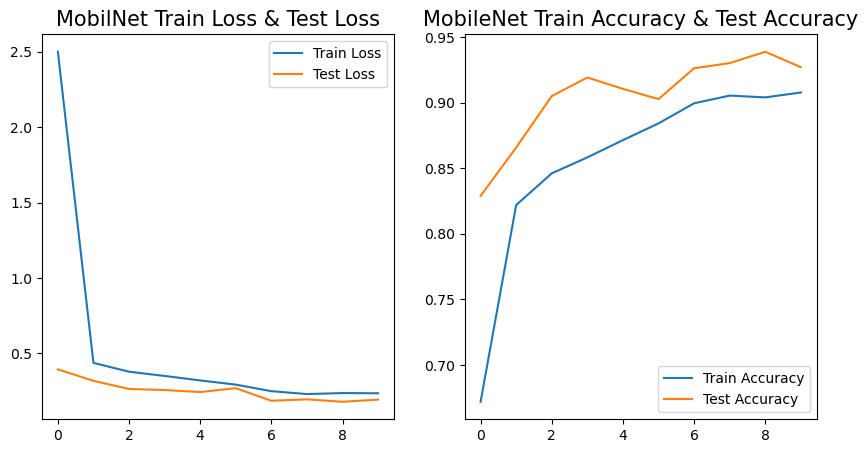

In [204]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(histMN1_['loss'],label='Train Loss')
plt.plot(histMN1_['val_loss'],label='Test Loss')
plt.title('MobilNet Train Loss & Test Loss',fontsize=15)
plt.legend()
plt.subplot(1,2,2)
plt.plot(histMN1_['accuracy'],label='Train Accuracy')
plt.plot(histMN1_['val_accuracy'],label='Test Accuracy')
plt.title('MobileNet Train Accuracy & Test Accuracy',fontsize=15)
plt.legend()
plt.show()

The shape of this graphs is really similar to the one we have already seen.

In [224]:
scoreMN1, accMN1= MNmodel1.evaluate(X_test1,y_test1)
print('Test Loss =', scoreMN1)
print('Test Accuracy =', accMN1)

40/40 [==============================] - 3s 73ms/step - loss: 0.1940 - accuracy: 0.9270
Test Loss = 0.19400687515735626
Test Accuracy = 0.9270015954971313


The statistics of this model are amazing, the accuracy is really high, and the loss pretty low.

In [206]:
predictionsMN1 = MNmodel1.predict(X_test1)
y_pred1 = np.argmax(predictionsMN1,axis=1)
y_test1_ = np.argmax(y_test1,axis=1)
dfMN1 = pd.DataFrame({'Actual': y_test1_, 'Prediction': y_pred1})
dfMN1

40/40 [==============================] - 4s 78ms/step


Actual  Prediction
0          2           0
1          3           3
2          3           3
3          1           1
4          2           2
...      ...         ...
1269       0           0
1270       2           2
1271       0           0
1272       2           2
1273       3           3

[1274 rows x 2 columns]

array([[300,   0,   8,  10],
       [  0, 319,   0,   0],
       [ 29,   0, 262,  27],
       [  3,   1,  15, 300]], dtype=int64)

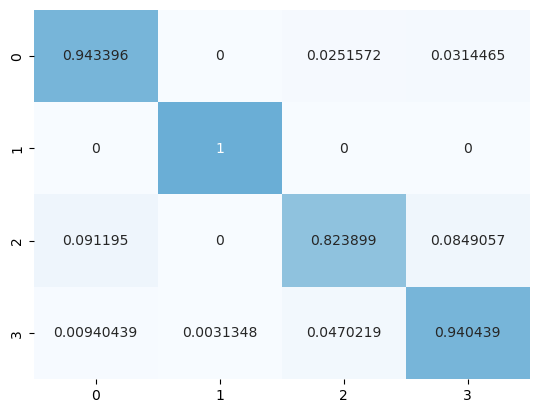

In [207]:
CMMN1 = confusion_matrix(y_test1_,y_pred1)
CM_percent1 = CMMN1.astype('float') / CMMN1.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent1,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CMMN1

In [208]:
ClassificationReportMN1 = classification_report(y_test1_,y_pred1)
print(' MobileNet Classification Report is : ', ClassificationReportMN1 )

 MobileNet Classification Report is :                precision    recall  f1-score   support

           0       0.90      0.94      0.92       318
           1       1.00      1.00      1.00       319
           2       0.92      0.82      0.87       318
           3       0.89      0.94      0.91       319

    accuracy                           0.93      1274
   macro avg       0.93      0.93      0.93      1274
weighted avg       0.93      0.93      0.93      1274



This is the best model we have seen until now, it is almost perfectly fitting our data.

### 4.6 EfficientNet

In [209]:
modelEN1 = EfficientNetB0(weights='imagenet', include_top=False,input_shape=(100,100, 3))

In [210]:
for layer1 in modelEN1.layers:
            layer1.trainable = False

In [211]:
x = layers.Flatten()(modelEN1.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)

predictions1 = layers.Dense(4,activation='softmax')(x)

ENmodel1 = Model(inputs=modelEN1.input, outputs=predictions1)
ENmodel1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [212]:
history1 = ENmodel1.fit(X_train1, y_train1, batch_size=64, epochs=10, validation_data=(X_test1, y_test1))

Epoch 1/10
80/80 [==============================] - 55s 621ms/step - loss: 3.6916 - accuracy: 0.2534 - val_loss: 1.3863 - val_accuracy: 0.2504
Epoch 2/10
80/80 [==============================] - 47s 586ms/step - loss: 1.3871 - accuracy: 0.2422 - val_loss: 1.3863 - val_accuracy: 0.2496
Epoch 3/10
80/80 [==============================] - 48s 596ms/step - loss: 1.3863 - accuracy: 0.2454 - val_loss: 1.3863 - val_accuracy: 0.2504
Epoch 4/10
80/80 [==============================] - 48s 599ms/step - loss: 1.3894 - accuracy: 0.2314 - val_loss: 1.3863 - val_accuracy: 0.2504
Epoch 5/10
80/80 [==============================] - 48s 597ms/step - loss: 1.3863 - accuracy: 0.2436 - val_loss: 1.3863 - val_accuracy: 0.2496
Epoch 6/10
80/80 [==============================] - 48s 602ms/step - loss: 1.3930 - accuracy: 0.2383 - val_loss: 1.3863 - val_accuracy: 0.2504
Epoch 7/10
80/80 [==============================] - 47s 592ms/step - loss: 1.3863 - accuracy: 0.2475 - val_loss: 1.3863 - val_accuracy: 0.2496

In [213]:
histEN1_=pd.DataFrame(history1.history)
histEN1_

loss  accuracy  val_loss  val_accuracy
0  3.691563  0.253435  1.386294      0.250392
1  1.387098  0.242246  1.386295      0.249608
2  1.386339  0.245387  1.386294      0.250392
3  1.389432  0.231449  1.386294      0.250392
4  1.386330  0.243620  1.386297      0.249608
5  1.393033  0.238320  1.386300      0.250392
6  1.386341  0.247546  1.386301      0.249608
7  1.386350  0.249509  1.386296      0.249608
8  1.386361  0.245387  1.386296      0.250392
9  1.393632  0.241853  1.386300      0.249608

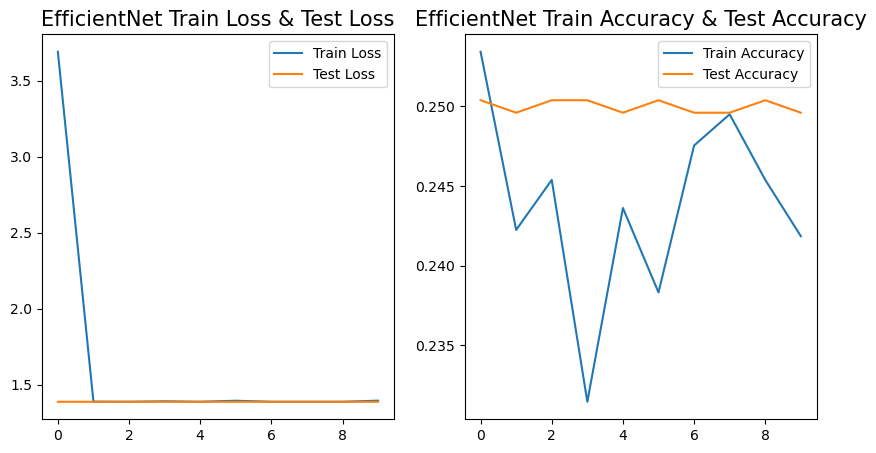

In [214]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(histEN1_['loss'],label='Train Loss')
plt.plot(histEN1_['val_loss'],label='Test Loss')
plt.title('EfficientNet Train Loss & Test Loss',fontsize=15)
plt.legend()
plt.subplot(1,2,2)
plt.plot(histEN1_['accuracy'],label='Train Accuracy')
plt.plot(histEN1_['val_accuracy'],label='Test Accuracy')
plt.title('EfficientNet Train Accuracy & Test Accuracy',fontsize=15)
plt.legend()
plt.show()

The shape of the loss function is always the same, but the level is really high, while the accuracy is totally unstable in the training set, and pretty stable in the validation, but around 25%.

In [215]:
scoreEN1, accEN1= ENmodel1.evaluate(X_test1,y_test1)
print('Test Loss =', scoreEN1)
print('Test Accuracy =', accEN1)

40/40 [==============================] - 6s 145ms/step - loss: 1.3863 - accuracy: 0.2496
Test Loss = 1.3863000869750977
Test Accuracy = 0.24960753321647644


This result is the worst possible. The loss is huge and the accuracy even lower then 25%.

In [216]:
predictionsEN1 = ENmodel1.predict(X_test1)
y_pred1 = np.argmax(predictionsEN1,axis=1)
y_test1_ = np.argmax(y_test1,axis=1)
dfEN1 = pd.DataFrame({'Actual': y_test1_, 'Prediction': y_pred1})
dfEN1

40/40 [==============================] - 7s 138ms/step


Actual  Prediction
0          2           2
1          3           2
2          3           2
3          1           2
4          2           2
...      ...         ...
1269       0           2
1270       2           2
1271       0           2
1272       2           2
1273       3           2

[1274 rows x 2 columns]

array([[  0,   0, 318,   0],
       [  0,   0, 319,   0],
       [  0,   0, 318,   0],
       [  0,   0, 319,   0]], dtype=int64)

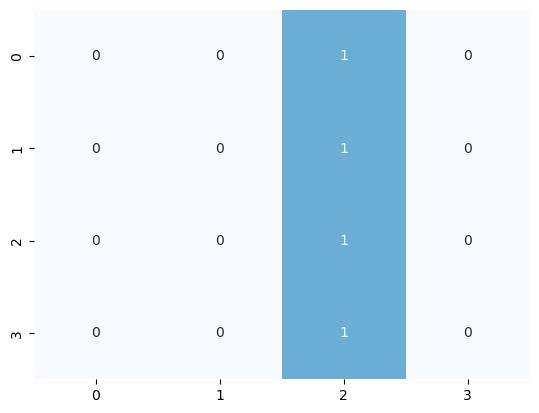

In [217]:
CMEN1 = confusion_matrix(y_test1_,y_pred1)
CM_percent1 = CMEN1.astype('float') / CMEN1.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent1,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CMEN1

In [218]:
ClassificationReportEN1 = classification_report(y_test1_,y_pred1)
print(' EfficientNet Classification Report is : ', ClassificationReportEN1 )

 EfficientNet Classification Report is :                precision    recall  f1-score   support

           0       0.00      0.00      0.00       318
           1       0.00      0.00      0.00       319
           2       0.25      1.00      0.40       318
           3       0.00      0.00      0.00       319

    accuracy                           0.25      1274
   macro avg       0.06      0.25      0.10      1274
weighted avg       0.06      0.25      0.10      1274



We can see that this model is completly unable to split our data into classes.

## Results

We can see that with the two techniques the models that perform well and the one that do not perform at all are always the same. The only difference is that with the data augmentation the models that better fit on our data have an accuarcy that is way higher then the one used for split our data in two classes.

In conclusion, MobileNet with data augmentation is the best model for our data.

# GradCAM interpretation 

CAM (class activation map) is a method of explaining which part of the image is most used by the machine to make the prediction.   
The main problem with this method is that it relies on the output of the global average pooling layer, which we do not always have in our models.

For this we have to use the generalization of CAM, based on the gradient.


**Gradient model** is constructed using:  
 - the input image  
 - the output of the final convolution layer (4d), meaning usually the output before the softmax   
 - the final prediction of the whole model  
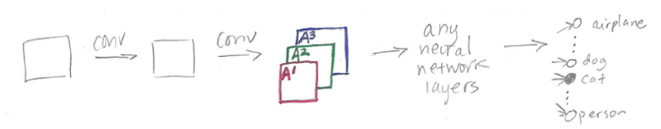

**Step1**

Compute the gradient of the loss function for the final convolution layer with respect to each feature map (in our case 3, one for each coulour), considering a specific class C.
  
This will tell us how the final predictions change with respect to changes in the convolution output layer (how final predictins changes with respect to changes in feature map).

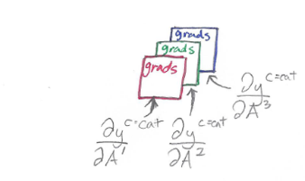

**Step2**  

Average the gradients for each feature map in order to express each of the tree feature map RGB as a single number isntead of an array (these are called "alpha coefficients").

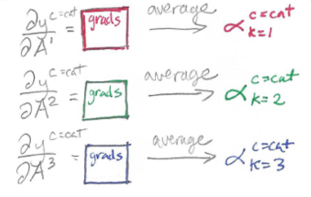

**Step3**

CAM for the class is the weighted sum of feature map by its alpha coefficient

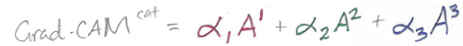

**Step4**

Reshape the GradCAM to overlay it on the image (The gradcam is smaller therefore much grainier)


In [219]:
# MAKE CLASS GRADCAM 
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None take output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM not applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # Gradient model is constructed for computing gradients of output with respect to the last layer weights
        # computed using: 
        # (1) the input image
        # (2) the output of the final convolution layer (4d)
        # (3) the output of the softmax activations from the model (predictions)
        
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # Compute the gradients of how loss change given convolution layer activation 
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type
            inputs = tf.cast(image, tf.float32)
            # image throug gradient model 
            (convOutputs, predictions) = gradModel(inputs)
            # check the loss
            loss = predictions[:, tf.argmax(predictions[0])]
    

        grads = tape.gradient(loss, convOutputs)

        # Guided gradients are the output of last convolutioon layer weighted by the gradient precedently computed
        # It tells us wich image part is more important for loss reduction
        # so we filter out negative ones that tell us parts of the iamge that reduce the probability of the class
        
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # Filters ponderation: average of guided gradients used for ponderation of convolution layer, returning the filter importance for predicting class
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # CAM is resized to match the input image to generate heatmap
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
       
        # heatmap scaled to uint8
        
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [244]:
image= cv2.imread(df.image[1])
image=cv2.resize(img,(100,100))

In [245]:
# Predict the image using the model, in this case we tried MobileNet
image= image.astype('float32') / 255
image= np.expand_dims(image, axis=0)

preds= MNmodel1.predict(image)

1/1 [==============================] - 0s 62ms/step


In [246]:
# Make the heatmap of the Gradcam based on last convolution layer of the model and fit it to the image 
icam = GradCAM(MNmodel1, preds, 'conv_pw_13_relu') 
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (100, 100))

In [247]:
# rechange shape of image to (100,100) for overlay it to heatmap 
image = cv2.imread(df.image[1])
image = cv2.resize(image, (100,100))


print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(100, 100) (100, 100, 3)


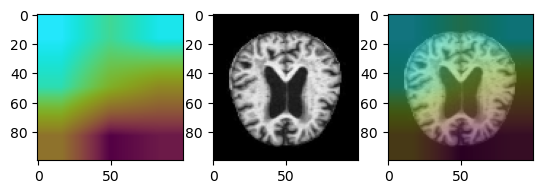

In [248]:
# Plot the heatmap 
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

In this example, therefore, it seems that the machine considered more the middle-lower part of the image to predict the class.